In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=10, roi=2500, offset=5000,gclass_num=5,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/Journal_2"
    parent_dir = "/home/rimali2009/Journal_2"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g4_j2_roi770_jogan_5500_400grid"
    file_list = ['/home/rimali2009/Journal_2/eta_5500_g6_300grid_jogan_g4_rw820_400grid.csv']
    initial_conditions = ['/home/rimali2009/Journal_2/start_param_random_5500_jogan_g4_rw820_400grid.csv']
    connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=4, topodx=10., roi=770)
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"


#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/Journal_2/data_g4_j2_roi770_jogan_5500_400grid/'
    resdir = '/home/rimali2009/Journal_2/result_g4_j2_roi770_jogan_5500_400grid/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [4500,5000]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)

Using TensorFlow backend.


Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 9s 2ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0622 - val_mean_squared_error: 0.0622
Epoch 2/2000
3600/3600 [==============================] - 1s 239us/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 3/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 4/2000
3600/3600 [==============================] - 1s 250us/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 5/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 6/2000
3600/3600 [==============================] - 1s 238us/step - loss: 0.0366 - mean_squared_error: 0.0366

3600/3600 [==============================] - 1s 252us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 98/2000
3600/3600 [==============================] - 1s 251us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 99/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 100/2000
3600/3600 [==============================] - 1s 256us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 101/2000
3600/3600 [==============================] - 1s 269us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 102/2000
3600/3600 [==============================] - 1s 244us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0113 - val_mean_squared_error: 0.01

3600/3600 [==============================] - 1s 297us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 194/2000
3600/3600 [==============================] - 1s 306us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 195/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 196/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 197/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 198/2000
3600/3600 [==============================] - 1s 298us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0097 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 302us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 290/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 291/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 292/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 293/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 294/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0066 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 285us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 386/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 387/2000
3600/3600 [==============================] - 1s 303us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 388/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 389/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 390/2000
3600/3600 [==============================] - 1s 305us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0062 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 298us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 482/2000
3600/3600 [==============================] - 1s 305us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 483/2000
3600/3600 [==============================] - 1s 271us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 484/2000
3600/3600 [==============================] - 1s 312us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 485/2000
3600/3600 [==============================] - 1s 298us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 486/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0060 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 296us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 578/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 579/2000
3600/3600 [==============================] - 1s 298us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 580/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 581/2000
3600/3600 [==============================] - 1s 282us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 582/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0061 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 288us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 674/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 675/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 676/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 677/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 678/2000
3600/3600 [==============================] - 1s 285us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0053 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 293us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 770/2000
3600/3600 [==============================] - 1s 251us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 771/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 772/2000
3600/3600 [==============================] - 1s 288us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 773/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 774/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0059 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 291us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 866/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 867/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 868/2000
3600/3600 [==============================] - 1s 255us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 869/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 870/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0051 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 290us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 962/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 963/2000
3600/3600 [==============================] - 1s 302us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 964/2000
3600/3600 [==============================] - 1s 285us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 965/2000
3600/3600 [==============================] - 1s 285us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 966/2000
3600/3600 [==============================] - 1s 258us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 278us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1058/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1059/2000
3600/3600 [==============================] - 1s 287us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1060/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1061/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1062/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0039 - val_mean_squared_erro

3600/3600 [==============================] - 1s 303us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1106/2000
3600/3600 [==============================] - 1s 284us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1107/2000
3600/3600 [==============================] - 1s 288us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1108/2000
3600/3600 [==============================] - 1s 301us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1109/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1110/2000
3600/3600 [==============================] - 1s 310us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0037 - val_mean_squared_erro

3600/3600 [==============================] - 1s 292us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1154/2000
3600/3600 [==============================] - 1s 304us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1155/2000
3600/3600 [==============================] - 1s 284us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1156/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1157/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1158/2000
3600/3600 [==============================] - 1s 302us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0044 - val_mean_squared_erro

3600/3600 [==============================] - 1s 287us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1202/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1203/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1204/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1205/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1206/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0046 - val_mean_squared_erro

3600/3600 [==============================] - 1s 301us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1250/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1251/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1252/2000
3600/3600 [==============================] - 1s 305us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1253/2000
3600/3600 [==============================] - 1s 280us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1254/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0038 - val_mean_squared_erro

3600/3600 [==============================] - 1s 295us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1298/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1299/2000
3600/3600 [==============================] - 1s 301us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1300/2000
3600/3600 [==============================] - 1s 310us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1301/2000
3600/3600 [==============================] - 1s 287us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1302/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_erro

3600/3600 [==============================] - 1s 288us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1346/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1347/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1348/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1349/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1350/2000
3600/3600 [==============================] - 1s 303us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0038 - val_mean_squared_erro

3600/3600 [==============================] - 1s 282us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1394/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1395/2000
3600/3600 [==============================] - 1s 287us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1396/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1397/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1398/2000
3600/3600 [==============================] - 1s 308us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_erro

3600/3600 [==============================] - 1s 290us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1442/2000
3600/3600 [==============================] - 1s 280us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1443/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1444/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 1445/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1446/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_erro

3600/3600 [==============================] - 1s 285us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1490/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1491/2000
3600/3600 [==============================] - 1s 253us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1492/2000
3600/3600 [==============================] - 1s 298us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1493/2000
3600/3600 [==============================] - 1s 285us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1494/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0033 - val_mean_squared_erro

3600/3600 [==============================] - 1s 290us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1538/2000
3600/3600 [==============================] - 1s 285us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1539/2000
3600/3600 [==============================] - 1s 286us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1540/2000
3600/3600 [==============================] - 1s 261us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1541/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1542/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_erro

3600/3600 [==============================] - 1s 280us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1586/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1587/2000
3600/3600 [==============================] - 1s 305us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1588/2000
3600/3600 [==============================] - 1s 286us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1589/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1590/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_erro

3600/3600 [==============================] - 1s 289us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1634/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1635/2000
3600/3600 [==============================] - 1s 289us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1636/2000
3600/3600 [==============================] - 1s 298us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1637/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1638/2000
3600/3600 [==============================] - 1s 271us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_erro

3600/3600 [==============================] - 1s 295us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1682/2000
3600/3600 [==============================] - 1s 300us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1683/2000
3600/3600 [==============================] - 1s 289us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1684/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1685/2000
3600/3600 [==============================] - 1s 283us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1686/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_erro

3600/3600 [==============================] - 1s 267us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1730/2000
3600/3600 [==============================] - 1s 303us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1731/2000
3600/3600 [==============================] - 1s 296us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1732/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1733/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1734/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0036 - val_mean_squared_erro

3600/3600 [==============================] - 1s 296us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1778/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1779/2000
3600/3600 [==============================] - 1s 289us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1780/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1781/2000
3600/3600 [==============================] - 1s 299us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1782/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_erro

3600/3600 [==============================] - 1s 303us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1826/2000
3600/3600 [==============================] - 1s 291us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1827/2000
3600/3600 [==============================] - 1s 281us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1828/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1829/2000
3600/3600 [==============================] - 1s 293us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1830/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_erro

3600/3600 [==============================] - 1s 300us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1874/2000
3600/3600 [==============================] - 1s 295us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1875/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1876/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1877/2000
3600/3600 [==============================] - 1s 297us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1878/2000
3600/3600 [==============================] - 1s 302us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0046 - val_mean_squared_erro

3600/3600 [==============================] - 1s 294us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1922/2000
3600/3600 [==============================] - 1s 303us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1923/2000
3600/3600 [==============================] - 1s 292us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1924/2000
3600/3600 [==============================] - 1s 294us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1925/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1926/2000
3600/3600 [==============================] - 1s 303us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0045 - val_mean_squared_erro

3600/3600 [==============================] - 1s 295us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1970/2000
3600/3600 [==============================] - 1s 301us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1971/2000
3600/3600 [==============================] - 1s 306us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1972/2000
3600/3600 [==============================] - 1s 290us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1973/2000
3600/3600 [==============================] - 1s 289us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1974/2000
3600/3600 [==============================] - 1s 286us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model
Train on 4000 samples, validate on 1000 samples
Epoch 1/2000
4000/4000 [==============================] - 2s 456us/step - loss: 0.0875 - mean_squared_error: 0.0875 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 2/2000
4000/4000 [==============================] - 1s 294us/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 3/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 4/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 5/2000
4000/4000 [==============================] - 1s 298us/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0370 - val_mean_squared_error: 0.0370
Epoch 6/2000
4000/4000 [==============================] - 1s 297us/step - loss: 0.0352 - mean_squ

4000/4000 [==============================] - 1s 288us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 98/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 99/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 100/2000
4000/4000 [==============================] - 1s 300us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 101/2000
4000/4000 [==============================] - 1s 298us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 102/2000
4000/4000 [==============================] - 1s 322us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0099 - val_mean_squared_error: 0.00

4000/4000 [==============================] - 1s 261us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 194/2000
4000/4000 [==============================] - 1s 298us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 195/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 196/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 197/2000
4000/4000 [==============================] - 1s 300us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 198/2000
4000/4000 [==============================] - 1s 325us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0067 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 314us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 290/2000
4000/4000 [==============================] - 1s 296us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 291/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 292/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 293/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 294/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0057 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 308us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 386/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 387/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 388/2000
4000/4000 [==============================] - 1s 318us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 389/2000
4000/4000 [==============================] - 1s 315us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 390/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0064 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 299us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 482/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 483/2000
4000/4000 [==============================] - 1s 319us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 484/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 485/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 486/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0063 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 297us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 578/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 579/2000
4000/4000 [==============================] - 1s 308us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 580/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 581/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 582/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0050 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 301us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 674/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 675/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 676/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 677/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 678/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0046 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 283us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 770/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 771/2000
4000/4000 [==============================] - 1s 320us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 772/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 773/2000
4000/4000 [==============================] - 1s 304us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 774/2000
4000/4000 [==============================] - 1s 318us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0055 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 317us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 866/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 867/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 868/2000
4000/4000 [==============================] - 1s 315us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 869/2000
4000/4000 [==============================] - 1s 289us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 870/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0039 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 322us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 962/2000
4000/4000 [==============================] - 1s 315us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 963/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 964/2000
4000/4000 [==============================] - 1s 298us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 965/2000
4000/4000 [==============================] - 1s 299us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 966/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0041 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 294us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1058/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1059/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1060/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1061/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1062/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0048 - val_mean_squared_erro

4000/4000 [==============================] - 1s 281us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1106/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1107/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1108/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1109/2000
4000/4000 [==============================] - 1s 296us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1110/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0052 - val_mean_squared_erro

4000/4000 [==============================] - 1s 306us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1154/2000
4000/4000 [==============================] - 1s 310us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1155/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1156/2000
4000/4000 [==============================] - 1s 306us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1157/2000
4000/4000 [==============================] - 1s 308us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1158/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0045 - val_mean_squared_erro

4000/4000 [==============================] - 1s 311us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1202/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1203/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1204/2000
4000/4000 [==============================] - 1s 308us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1205/2000
4000/4000 [==============================] - 1s 313us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1206/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0035 - val_mean_squared_erro

4000/4000 [==============================] - 1s 312us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1250/2000
4000/4000 [==============================] - 1s 305us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1251/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1252/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1253/2000
4000/4000 [==============================] - 1s 310us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1254/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_erro

4000/4000 [==============================] - 1s 298us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1298/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1299/2000
4000/4000 [==============================] - 1s 315us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1300/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1301/2000
4000/4000 [==============================] - 1s 312us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1302/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0046 - val_mean_squared_erro

4000/4000 [==============================] - 1s 305us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1346/2000
4000/4000 [==============================] - 1s 310us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1347/2000
4000/4000 [==============================] - 1s 299us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1348/2000
4000/4000 [==============================] - 1s 311us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1349/2000
4000/4000 [==============================] - 1s 327us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1350/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0049 - val_mean_squared_erro

4000/4000 [==============================] - 1s 294us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1394/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1395/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1396/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1397/2000
4000/4000 [==============================] - 1s 299us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1398/2000
4000/4000 [==============================] - 1s 281us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0046 - val_mean_squared_erro

4000/4000 [==============================] - 1s 303us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1442/2000
4000/4000 [==============================] - 1s 313us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1443/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1444/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1445/2000
4000/4000 [==============================] - 1s 299us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1446/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_erro

4000/4000 [==============================] - 1s 306us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1490/2000
4000/4000 [==============================] - 1s 304us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1491/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1492/2000
4000/4000 [==============================] - 1s 289us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1493/2000
4000/4000 [==============================] - 1s 297us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1494/2000
4000/4000 [==============================] - 1s 315us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_erro

4000/4000 [==============================] - 1s 304us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1538/2000
4000/4000 [==============================] - 1s 296us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1539/2000
4000/4000 [==============================] - 1s 313us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1540/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1541/2000
4000/4000 [==============================] - 1s 306us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1542/2000
4000/4000 [==============================] - 1s 300us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_erro

4000/4000 [==============================] - 1s 309us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1586/2000
4000/4000 [==============================] - 1s 314us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1587/2000
4000/4000 [==============================] - 1s 304us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1588/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1589/2000
4000/4000 [==============================] - 1s 303us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1590/2000
4000/4000 [==============================] - 1s 289us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0039 - val_mean_squared_erro

4000/4000 [==============================] - 1s 283us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1634/2000
4000/4000 [==============================] - 1s 306us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1635/2000
4000/4000 [==============================] - 1s 311us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1636/2000
4000/4000 [==============================] - 1s 301us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1637/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1638/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_erro

4000/4000 [==============================] - 1s 311us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1682/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1683/2000
4000/4000 [==============================] - 1s 310us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1684/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1685/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1686/2000
4000/4000 [==============================] - 1s 295us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0042 - val_mean_squared_erro

4000/4000 [==============================] - 1s 312us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1730/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1731/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1732/2000
4000/4000 [==============================] - 1s 313us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1733/2000
4000/4000 [==============================] - 1s 297us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1734/2000
4000/4000 [==============================] - 1s 305us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_erro

4000/4000 [==============================] - 1s 306us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1778/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1779/2000
4000/4000 [==============================] - 1s 319us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1780/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1781/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1782/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0042 - val_mean_squared_erro

4000/4000 [==============================] - 1s 311us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1826/2000
4000/4000 [==============================] - 1s 332us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1827/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1828/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1829/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1830/2000
4000/4000 [==============================] - 1s 308us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0042 - val_mean_squared_erro

4000/4000 [==============================] - 1s 298us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1874/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1875/2000
4000/4000 [==============================] - 1s 313us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1876/2000
4000/4000 [==============================] - 1s 306us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1877/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1878/2000
4000/4000 [==============================] - 1s 310us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0034 - val_mean_squared_erro

4000/4000 [==============================] - 1s 308us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1922/2000
4000/4000 [==============================] - 1s 309us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1923/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1924/2000
4000/4000 [==============================] - 1s 297us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1925/2000
4000/4000 [==============================] - 1s 304us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1926/2000
4000/4000 [==============================] - 1s 289us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0034 - val_mean_squared_erro

4000/4000 [==============================] - 1s 297us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1970/2000
4000/4000 [==============================] - 1s 307us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1971/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1972/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1973/2000
4000/4000 [==============================] - 1s 306us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1974/2000
4000/4000 [==============================] - 1s 300us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0033 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model


(500, 7)
Standard Deviation: 174.55054378120244
Standard Deviation sample: 174.72535658794072
Mean: 36.136261747126
CV: 4.835180733708213


/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


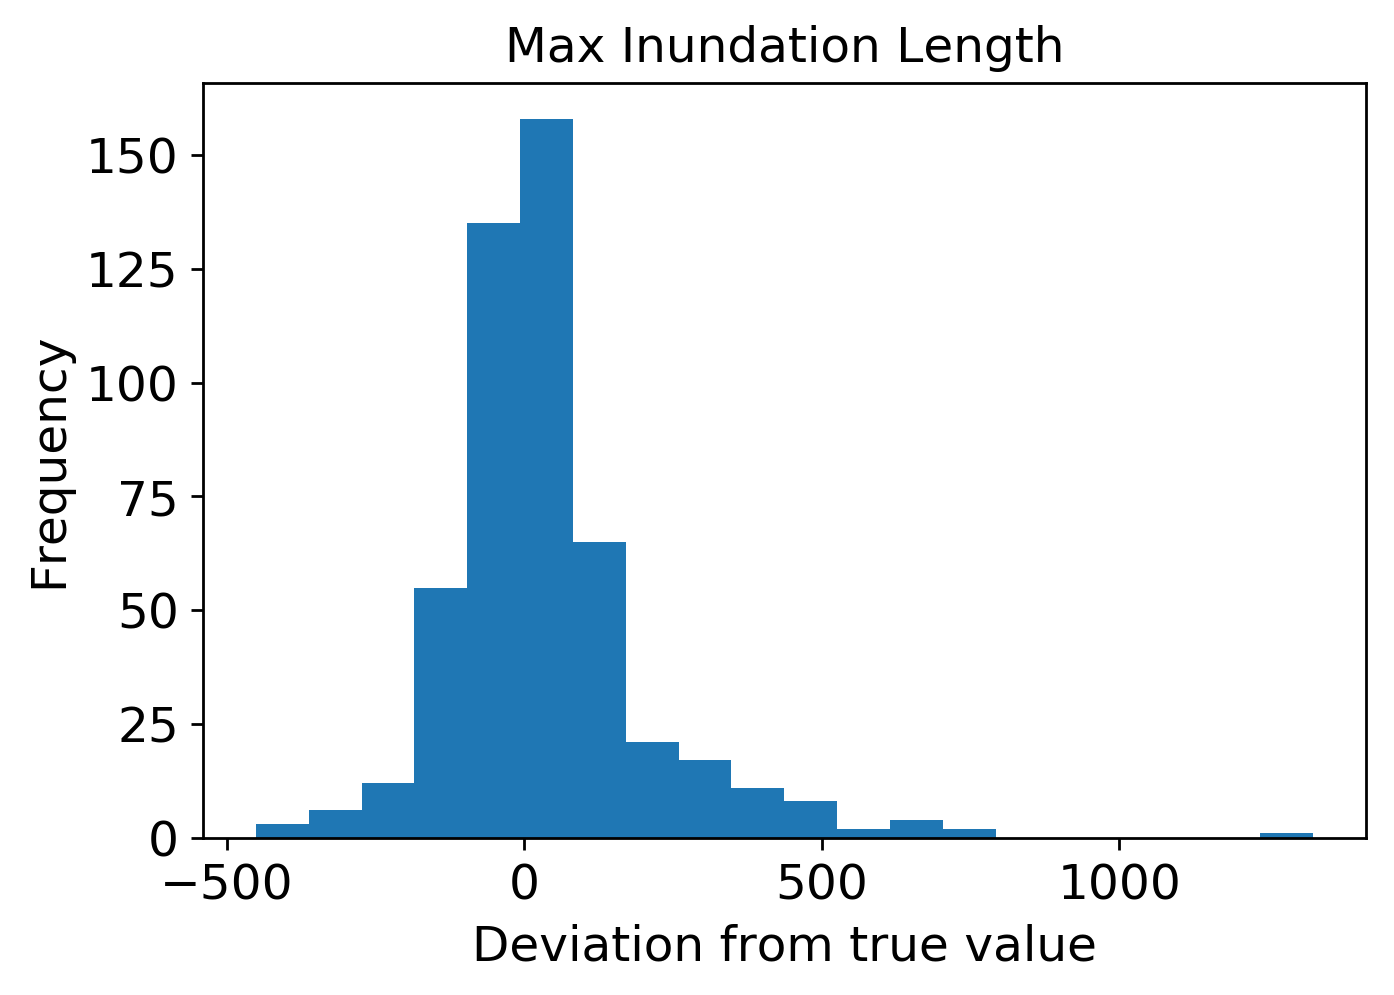

Standard Deviation: 0.5009427922401333
Standard Deviation sample: 0.5014444877011143
Mean: 0.12029361681988661
CV: 4.1685045387896


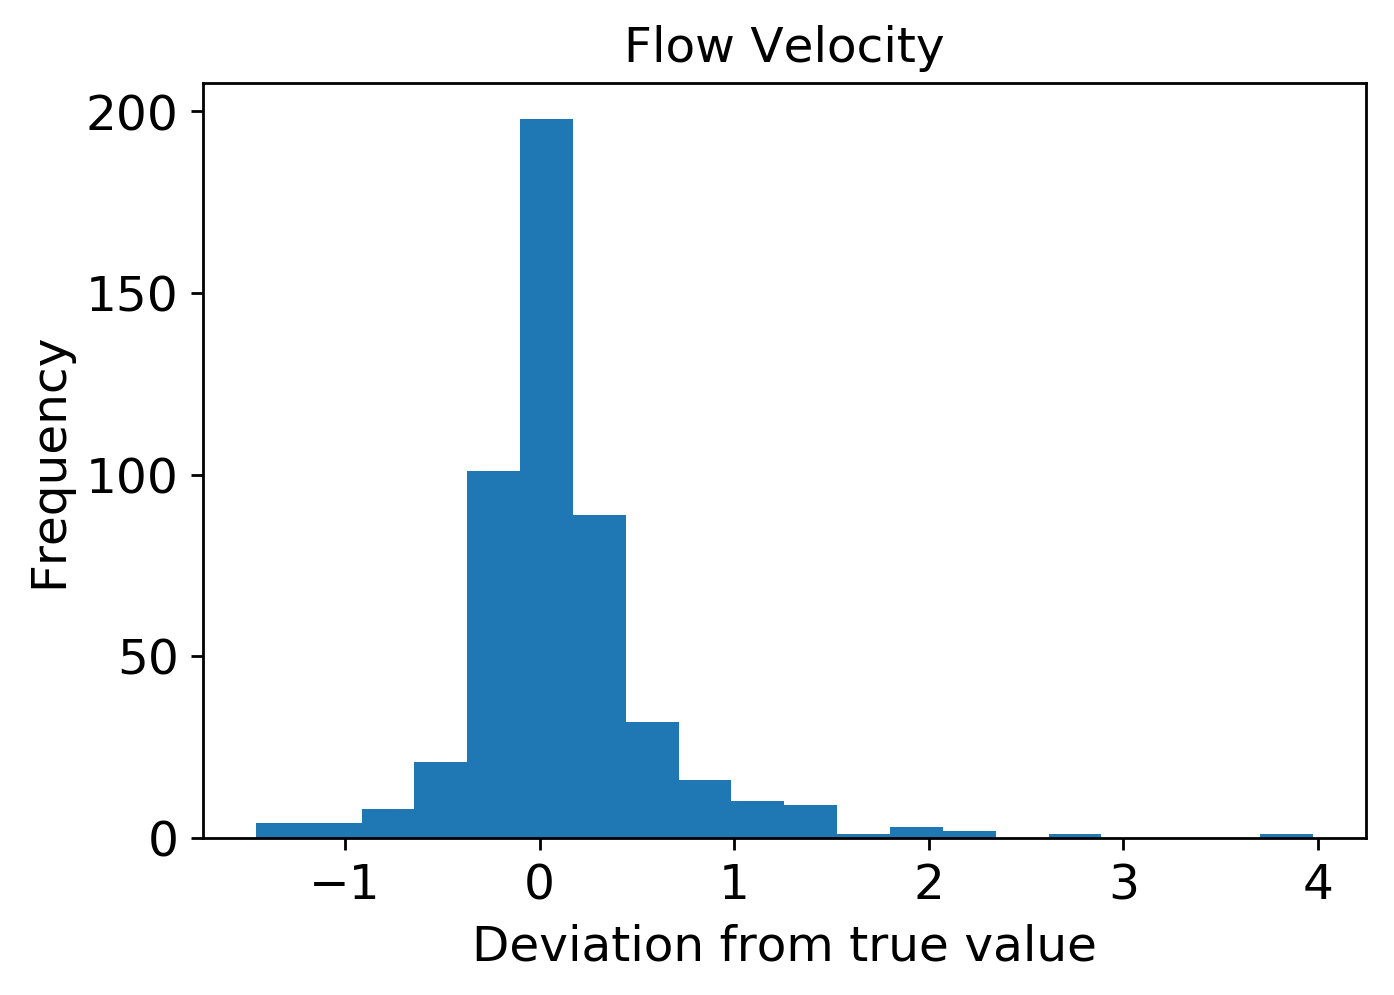

Standard Deviation: 0.7281278188075427
Standard Deviation sample: 0.7288570406415894
Mean: -0.7422448016698315
CV: -0.981963146123592


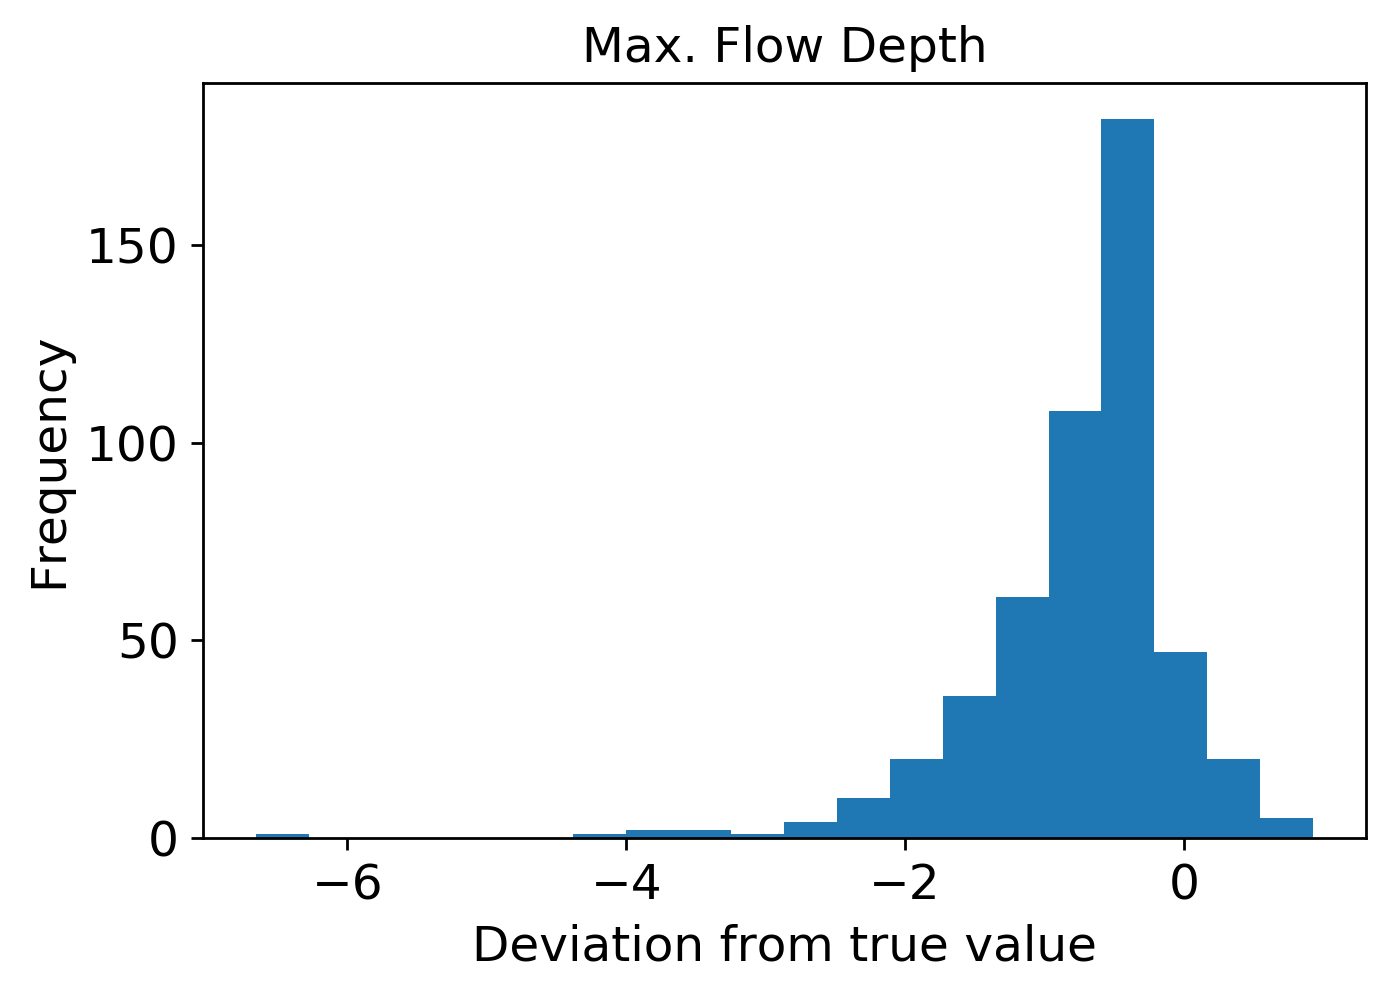

Standard Deviation: 0.0010918776318242839
Standard Deviation sample: 0.0010929711500070355
Mean: 0.0004750275736381633
CV: 2.3008583304672974


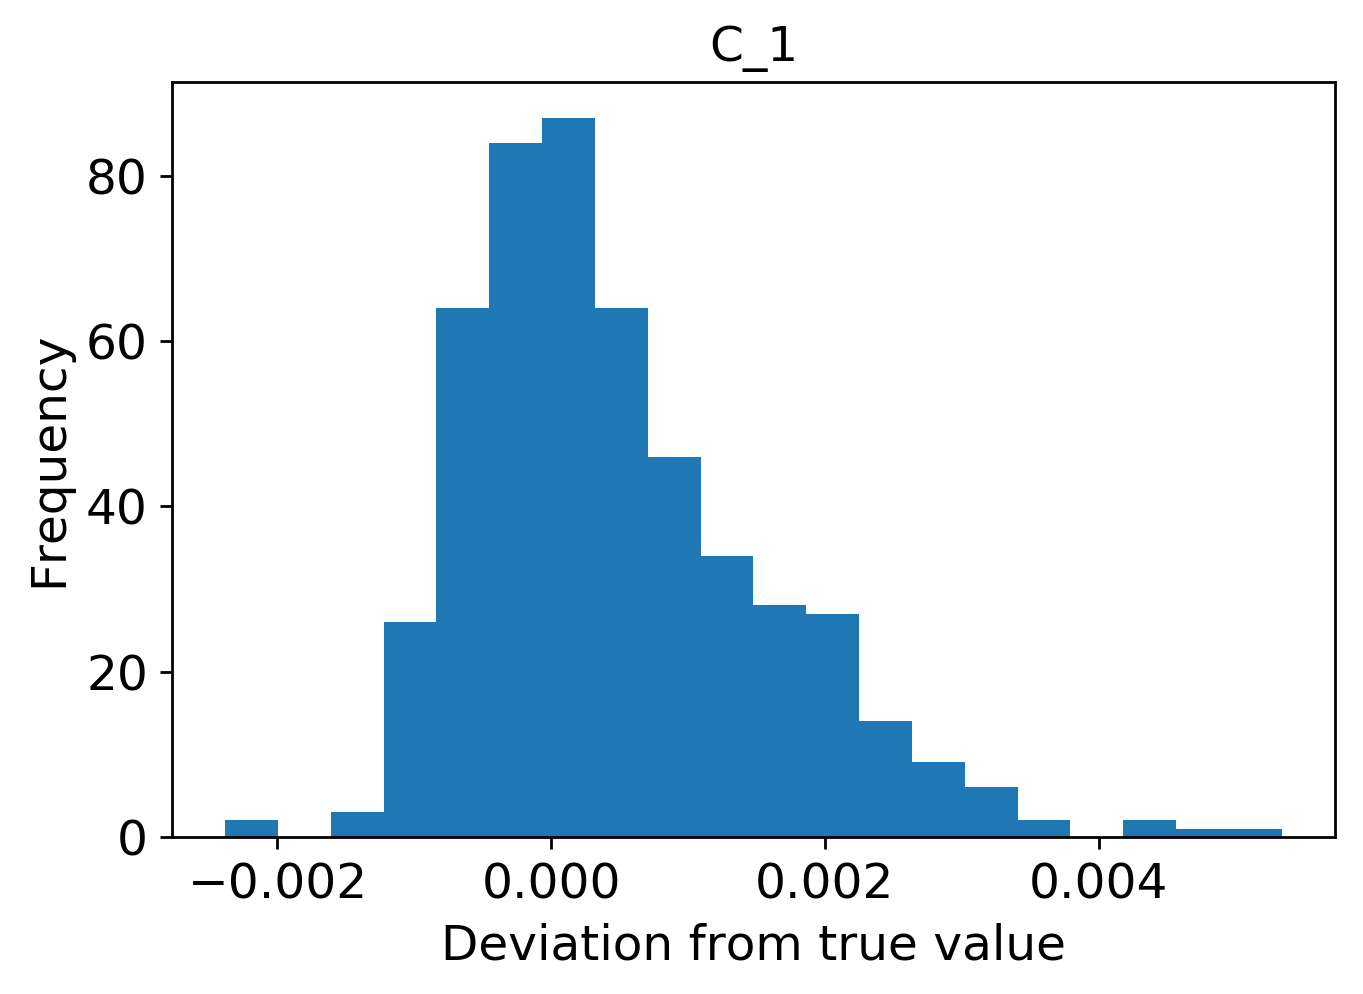

Standard Deviation: 0.001006700218231753
Standard Deviation sample: 0.0010077084310214748
Mean: 0.000427808892341007
CV: 2.3555107176646275


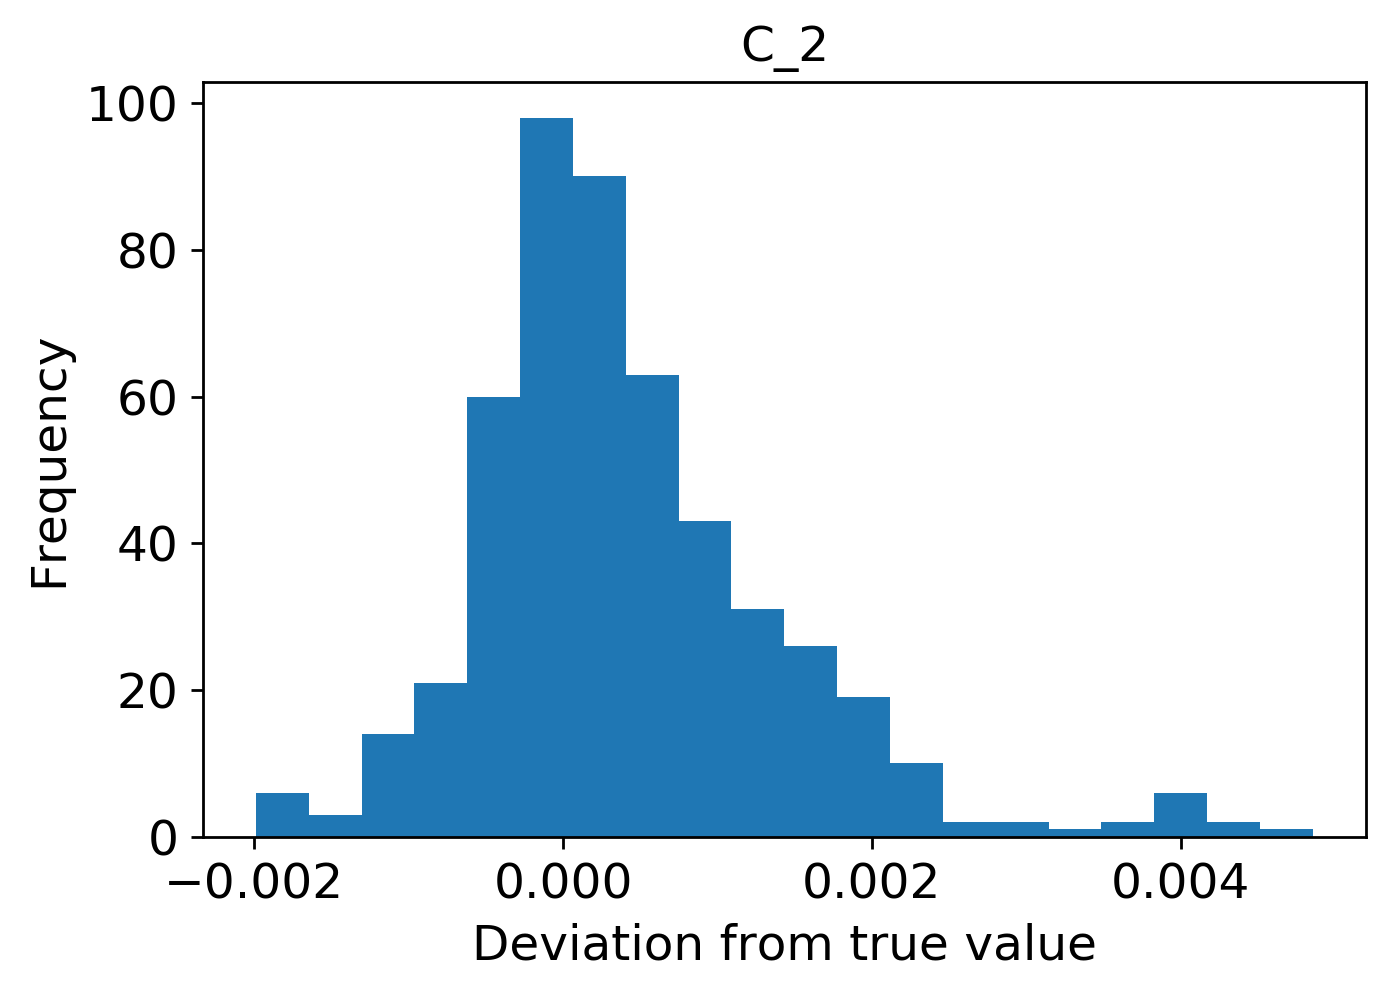

Standard Deviation: 0.0010739828381608814
Standard Deviation sample: 0.0010750584346629639
Mean: 0.0005075672233222119
CV: 2.118061185326972


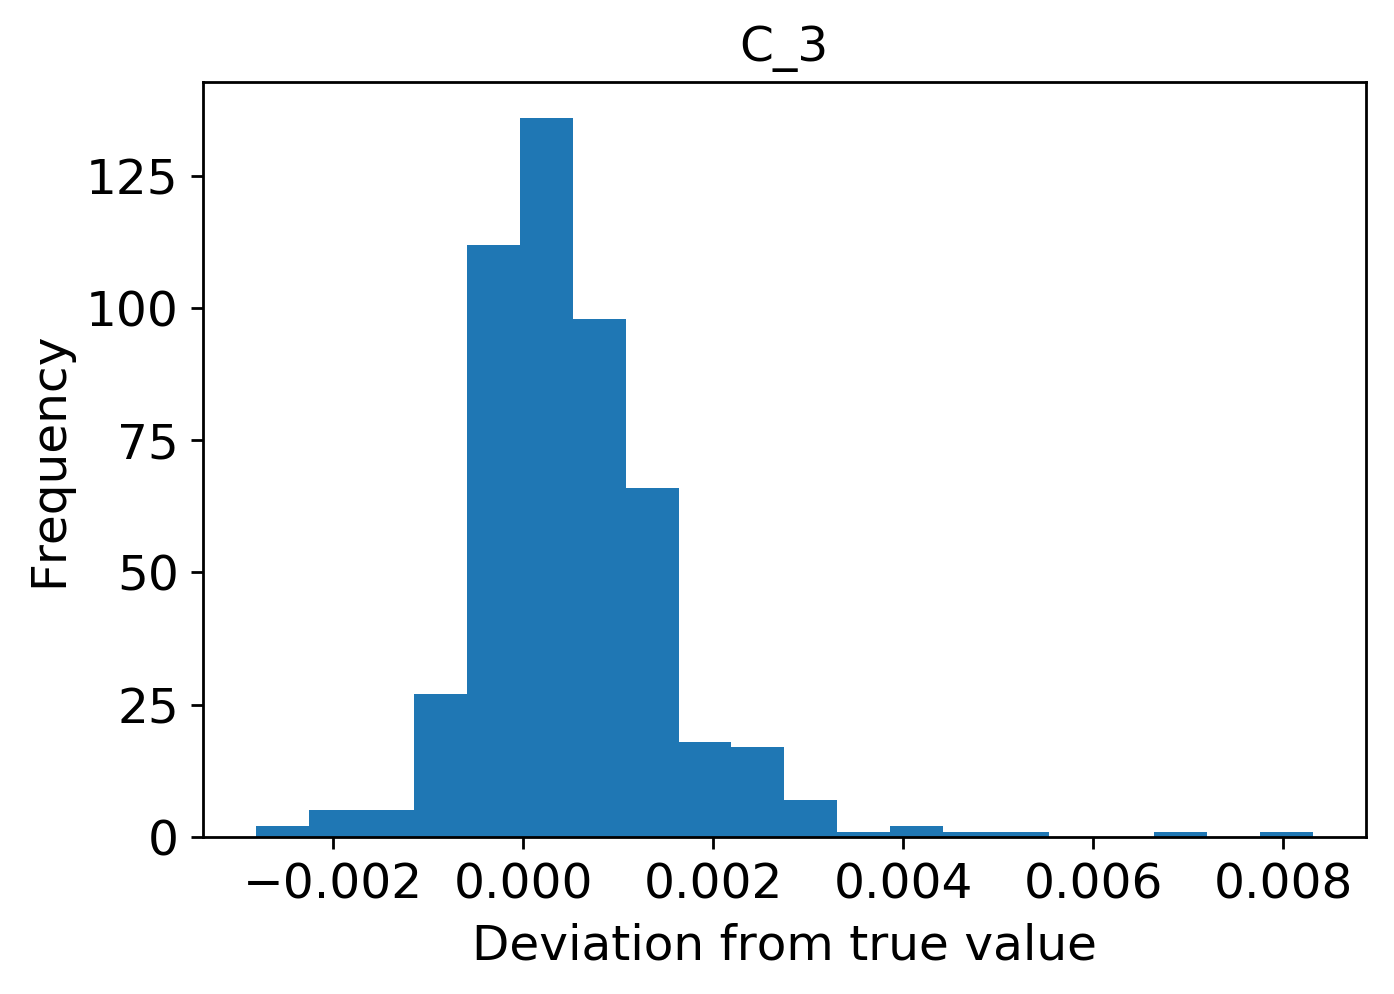

Standard Deviation: 0.0010802693909193902
Standard Deviation sample: 0.0010813512834198043
Mean: 0.0005011385573377394
CV: 2.157789033764237


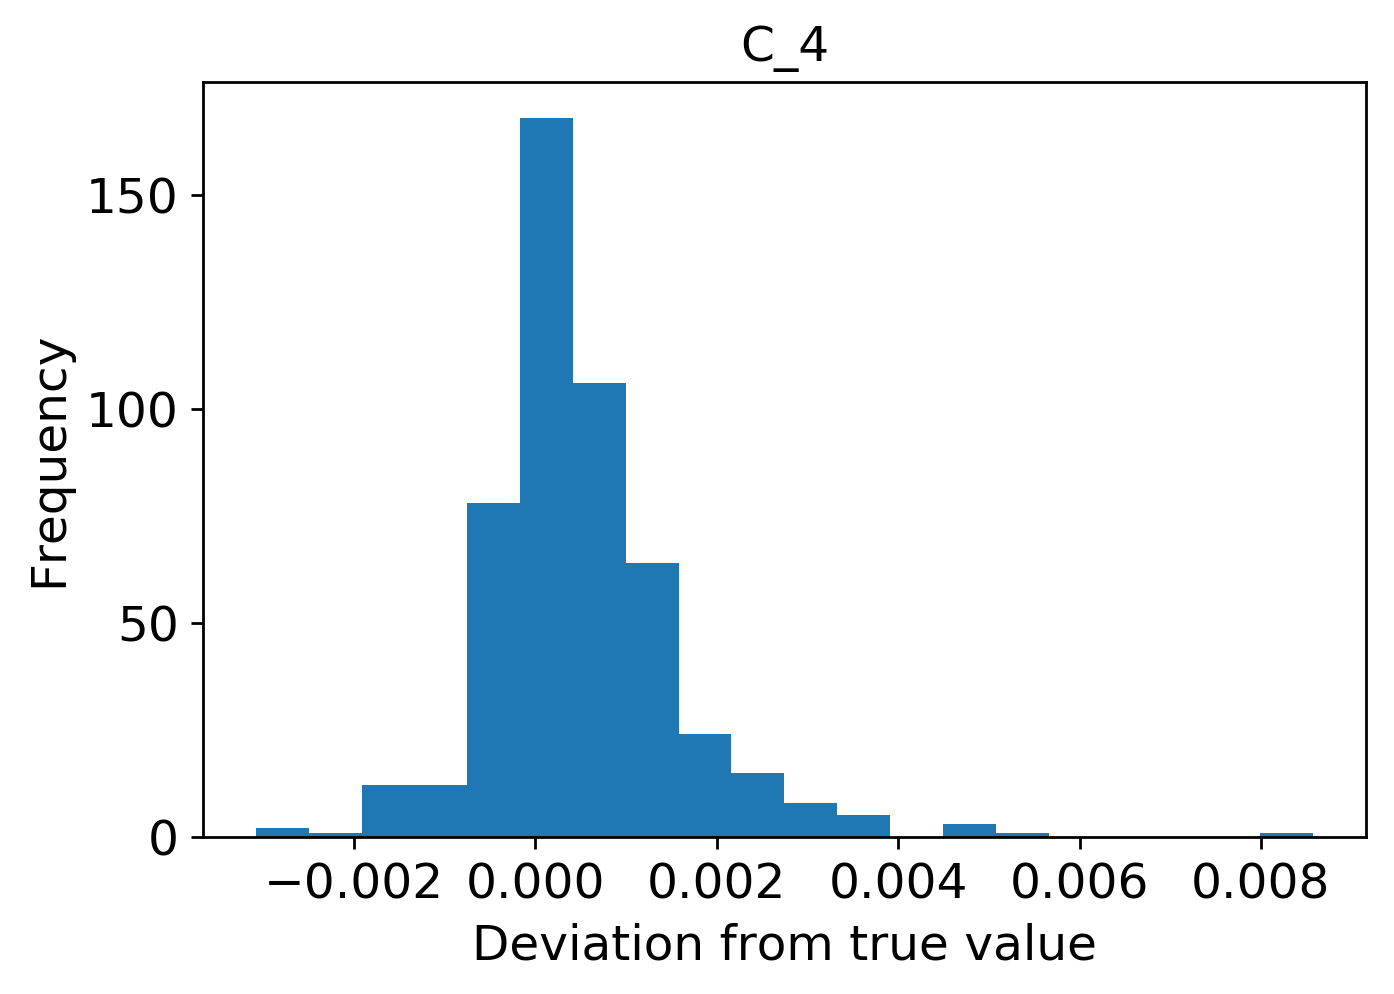

In [3]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

hfont = {'fontname':'Century Gothic'}
textcol = 'k'

datadir = '/home/rimali2009/Journal_2/data_g4_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g4_j2_roi770_jogan_5500_400grid/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

     distance       489       394       317       255
0    0.000000  0.038239  0.031478  0.011181  0.003198
1  109.646182  0.027764  0.022014  0.007247  0.001860
2  450.682215  0.010153  0.008097  0.002525  0.000523
3  543.078703  0.019464  0.017450  0.005963  0.001467
4  674.221738  0.017932  0.020203  0.009403  0.002442
5  766.825235  0.008901  0.011150  0.005928  0.001497
6  879.030860  0.001445  0.001811  0.000995  0.000255
7  965.302169  0.005323  0.007308  0.004965  0.001357
[[5.65840995e+03 4.30544539e+00 3.59771055e+00 1.21182722e-02
  1.24854046e-02 7.23738989e-03 2.10421797e-03]]


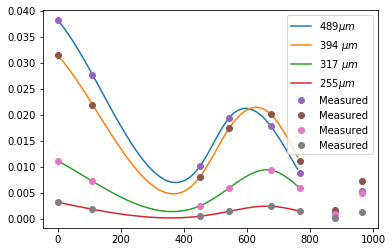

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/Journal_2/data_g4_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g4_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')
#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 4
gclass_label =  ["489${\mu}m$","394 ${\mu}m$", "317 ${\mu}m$","255${\mu}m$"]
gclass_name=['489','394','317','255']
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 22200. #Distance of distal end of learning data
outcrop = pd.read_csv('../Journal_2/jogan_gs4_range.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="quadratic",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],np.log10(outcrop.iloc[:,j+1]), kind="cubic",bounds_error=False,fill_value='extrapolate') 
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="cubic",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data


#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g4_g300_j2_roi770_jogan_5500_400grid.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
for i in range(gclass):
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
plt.legend()
plt.show()

<Figure size 1750x1000 with 2 Axes>

NameError: name 'read_setfile' is not defined

(5500, 7)
(5500, 1600)


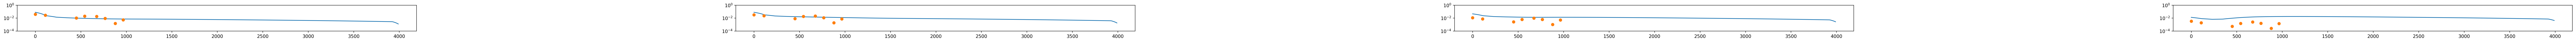

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_jogan_g4_Rw820_400grid as fmodel
import time
import ipdb
%matplotlib inline


#dist_max = 3000.
gclass = 4
topodx=10.0
#gclass_name = ['840microm','594microm','420microm','297microm','210microm','148microm']#gclass_name = ['500micron', '125micron', '63micron']
gclass_name=['489','394','317','255']
gname_tex = ["489${\mu}m$","394 ${\mu}m$", "317 ${\mu}m$","255${\mu}m$"]

estimated_icond=np.loadtxt('outcrop_result_g4_g300_j2_roi770_jogan_5500_400grid.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g4_400grid.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g4_j2_roi770_400grid.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g4_j2_roi770_400grid.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_thickness_5K_g4_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['489','394','317','255'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_Distance_5K_g4_j2_roi770_400grid.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g4_j2_roi770_400grid.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#print(estimated_dep_5000)

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
#estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))
#print(estimated_dep_5000)
#Read original data
outcrop = pd.read_csv('../Journal_2/jogan_gs4_range.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','489','394','317','255'])
#Plot
plt.figure(num=None, figsize=(100, 1), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.10, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.0001,1.0])
    #plt.xlim(-100,4000)
    plt.savefig("thickness_distance_curve_joganfinal_g4_2.png")
    


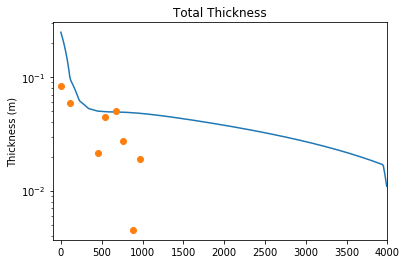

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_jogan_5gs_Rw820_400grid as fmodel
import time
import ipdb
%matplotlib inline

estimated_thick=pd.read_csv('estimated_thick.csv',delimiter=',')
estimated_thick= pd.DataFrame(estimated_thick,columns=['distance','500','420','354','297','250','thickness'])
#print(estimated_thick)
measured_thick=pd.read_csv('measured_thick.csv',delimiter=',')
measured_thick=pd.DataFrame(measured_thick,columns=['distance','thickness'])


#Plot

plt.plot(estimated_thick['distance'],estimated_thick['thickness'],'-',label='Estimated')
plt.plot(measured_thick['distance'],measured_thick['thickness'],'o',label='Measured')
plt.title('Total Thickness')
plt.ylabel('Thickness (m)')
plt.yscale("log")
plt.xlim(-100,4000)
plt.savefig('../thickness.png')
plt.savefig('../thickness.eps')
plt.show()








        

In [90]:
def plot_result(params, labels, xmin, xmax):
    
    deposit_c = []
    totalthick = []
    symbollist = ['-','-.','--',':','-','-.']
    
    #与えられたパラメーターから結果を計算する
    for j in range(len(params)):
        deposit_c.append([])
        totalthick.append([])
        (x, C, x_dep, deposit_c[j]) = fmodel.forward(params[j]) #最適解を計算
        cnum = fmodel.cnum #粒度階の数を取得
        totalthick[j] = np.sum(deposit_c[j],axis=0)
    
    #xのオフセット補正（解析では最初のデータ点の値が座標0となるようにしているため）
    x_dep = x_dep + spoints[0]
    
    
    #プロットの書式を整える
    plt.figure(num=None, figsize=(7, 8.5), dpi=150, facecolor='w', edgecolor='k')
    fp = FontProperties(size=9)
    plt.rcParams["font.size"] = 9
        
    plt.subplot(cnum+1,1,1)
    plt.plot(spoints, np.sum(deposit_o,axis=0),marker='o', markersize=4, fillstyle='none', linestyle = 'None', label = "Observation")
    for l in range(len(params)):
        plt.plot(x_dep[xmin:xmax], totalthick[l][xmin:xmax], symbollist[l], linewidth = 0.75, label = labels[l])
    plt.title('Total Thickness')
    plt.ylabel('Thickness (m)')
    plt.yscale("log")
    plt.ylim(0,0.4)
    plt.legend(prop = fp, loc='best', borderaxespad=1)




In [12]:
gclass = 4
#print(estimated_dep_5000['distance'])
for i in range(gclass):
    x = estimated_dep_5000['distance']
    y = estimated_dep_5000[gclass_name[i]]
    a=np.interp(965.302169,x,y)
    print(a)

0.007091881240983553
0.01201228795149744
0.013254904640757983
0.017275590781857114


Using TensorFlow backend.


     distance       489       394       317       255
0    0.000000  0.038239  0.031478  0.011181  0.003198
1  109.646182  0.027764  0.022014  0.007247  0.001860
2  450.682215  0.010153  0.008097  0.002525  0.000523
3  543.078703  0.019464  0.017450  0.005963  0.001467
4  674.221738  0.017932  0.020203  0.009403  0.002442
5  766.825235  0.008901  0.011150  0.005928  0.001497
6  879.030860  0.001445  0.001811  0.000995  0.000255
7  965.302169  0.005323  0.007308  0.004965  0.001357
     distance       489       394       317       255
0  109.646182  0.027764  0.022014  0.007247  0.001860
1  450.682215  0.010153  0.008097  0.002525  0.000523
2  543.078703  0.019464  0.017450  0.005963  0.001467
3  674.221738  0.017932  0.020203  0.009403  0.002442
4  766.825235  0.008901  0.011150  0.005928  0.001497
5  879.030860  0.001445  0.001811  0.000995  0.000255
6  965.302169  0.005323  0.007308  0.004965  0.001357
(1, 7)
[[5.42194187e+03 1.50028050e+00 4.78043002e+00 1.41388144e-02
  1.34496037e

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


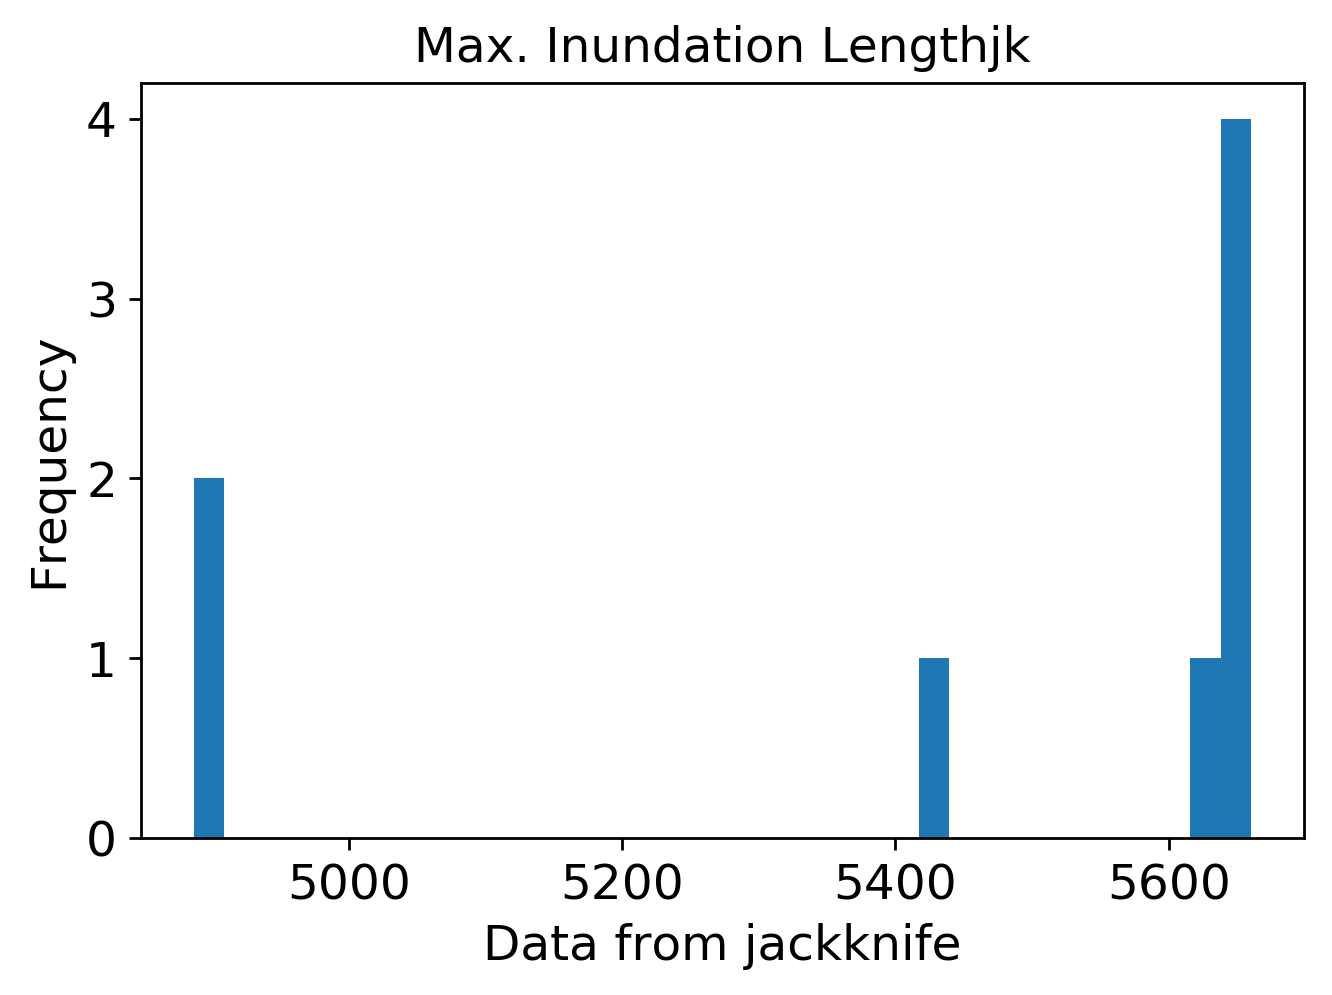

mean: 4.018097130507213
jk_e: 0.6273409165575698
CI 1.2295881964528368


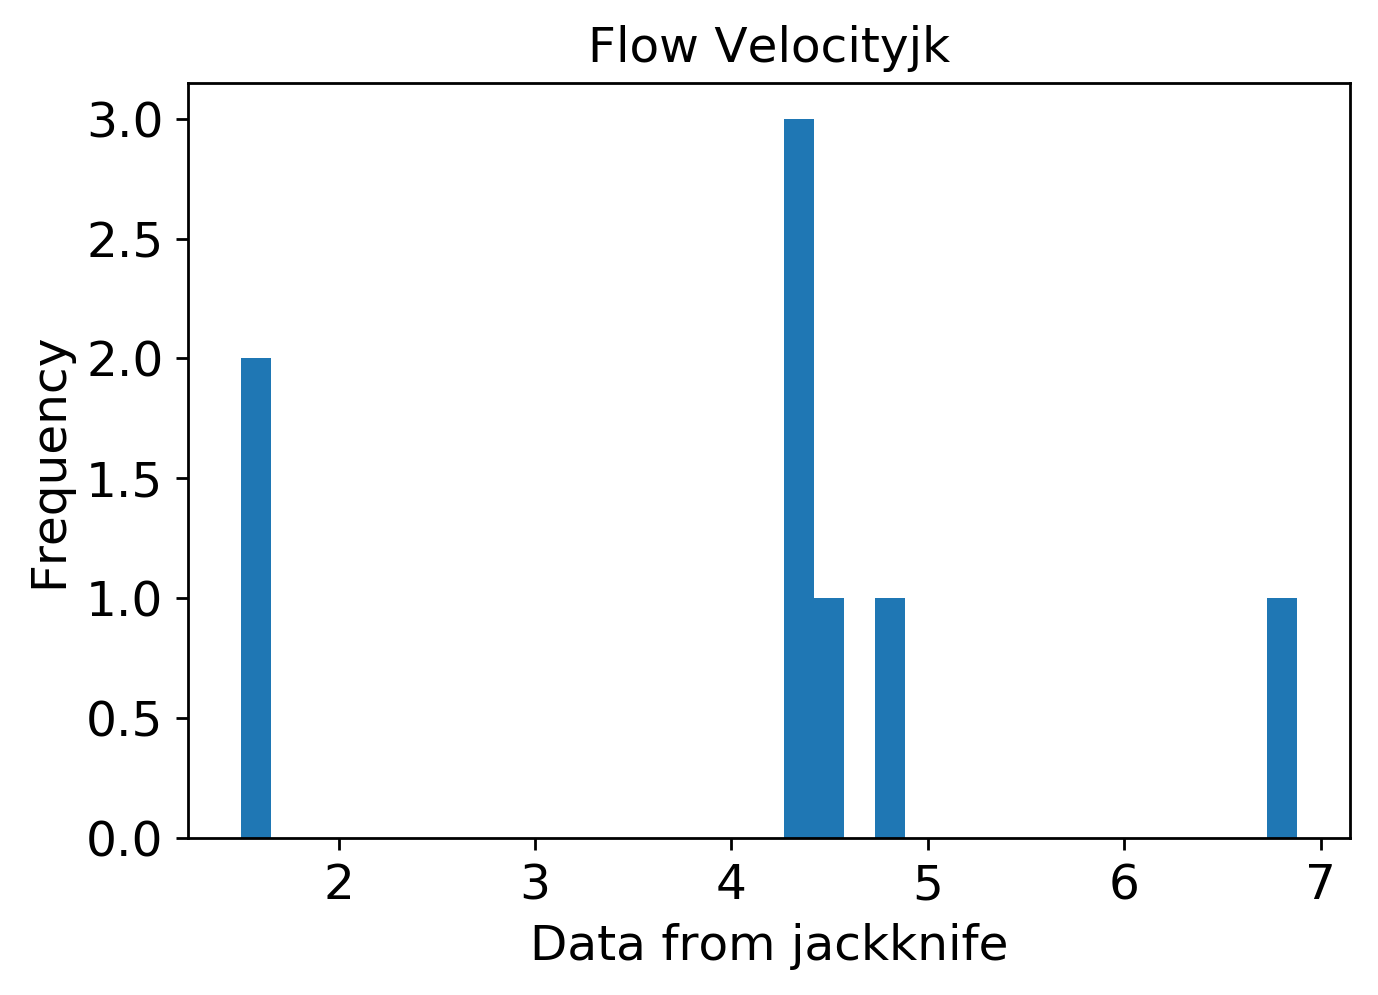

mean: 4.020987587587837
jk_e: 0.5337433504673663
CI 1.0461369669160379


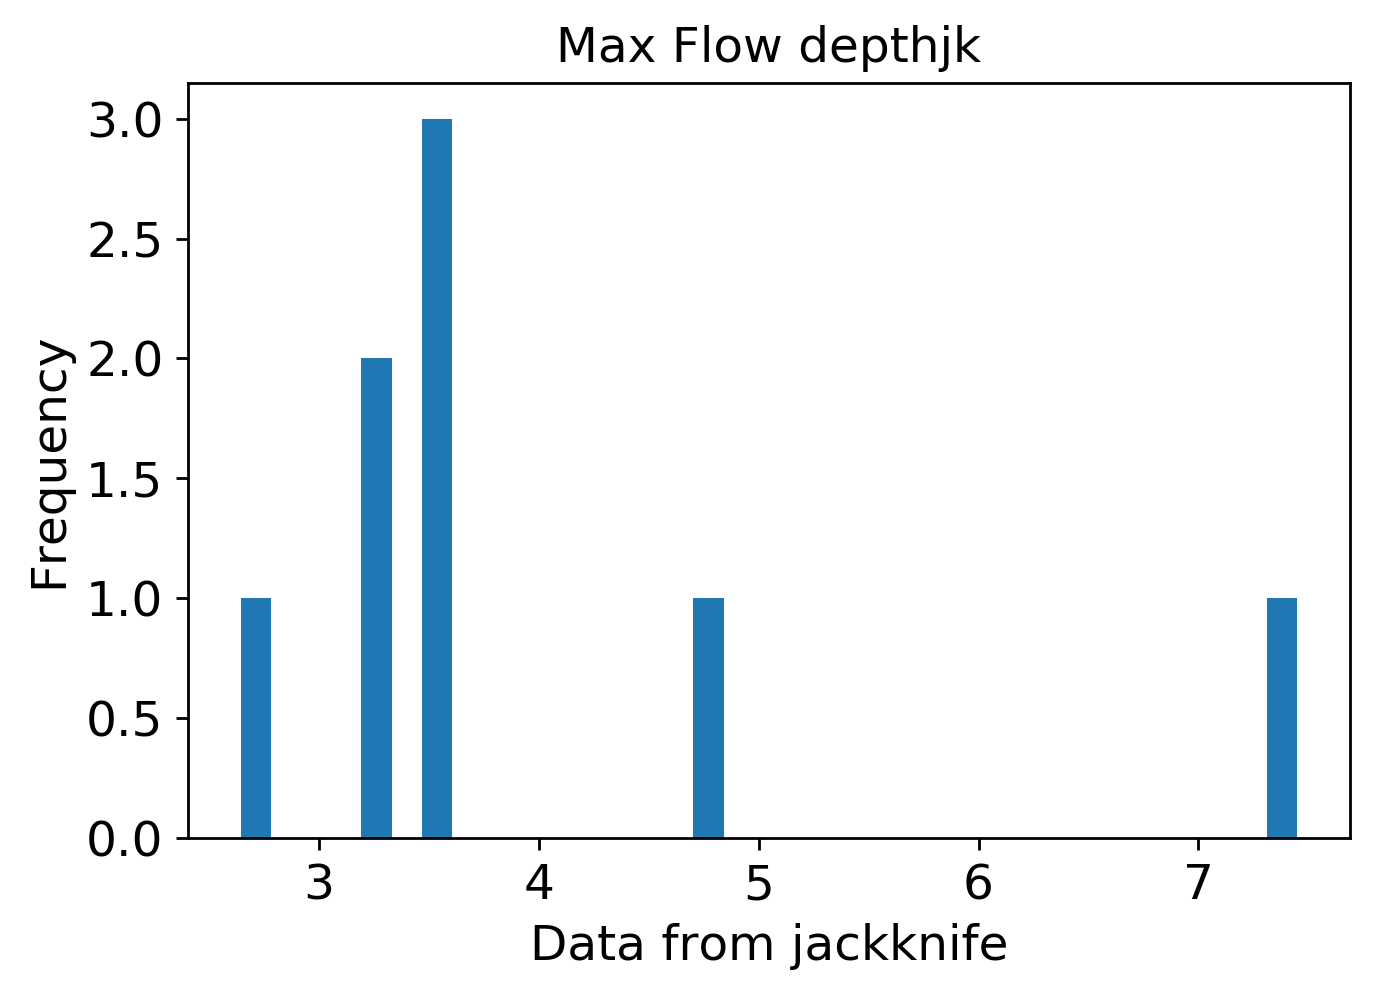

mean: 0.011769210310657297
jk_e: 0.001021511399860542
CI 0.002002162343726662


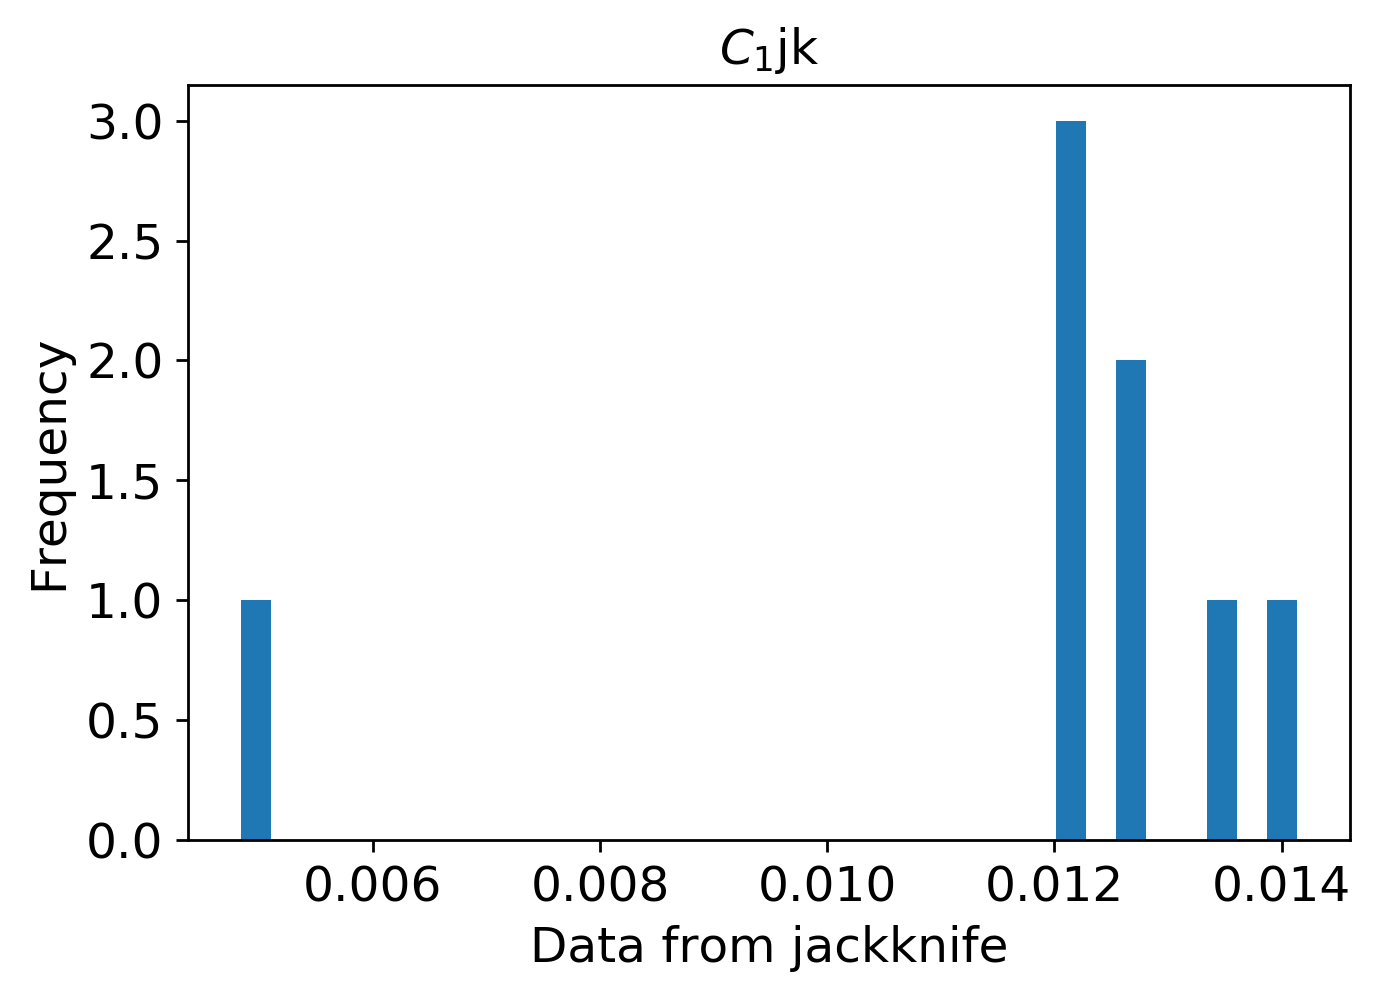

mean: 0.011778228061930674
jk_e: 0.0011107090354353032
CI 0.0021769897094531944


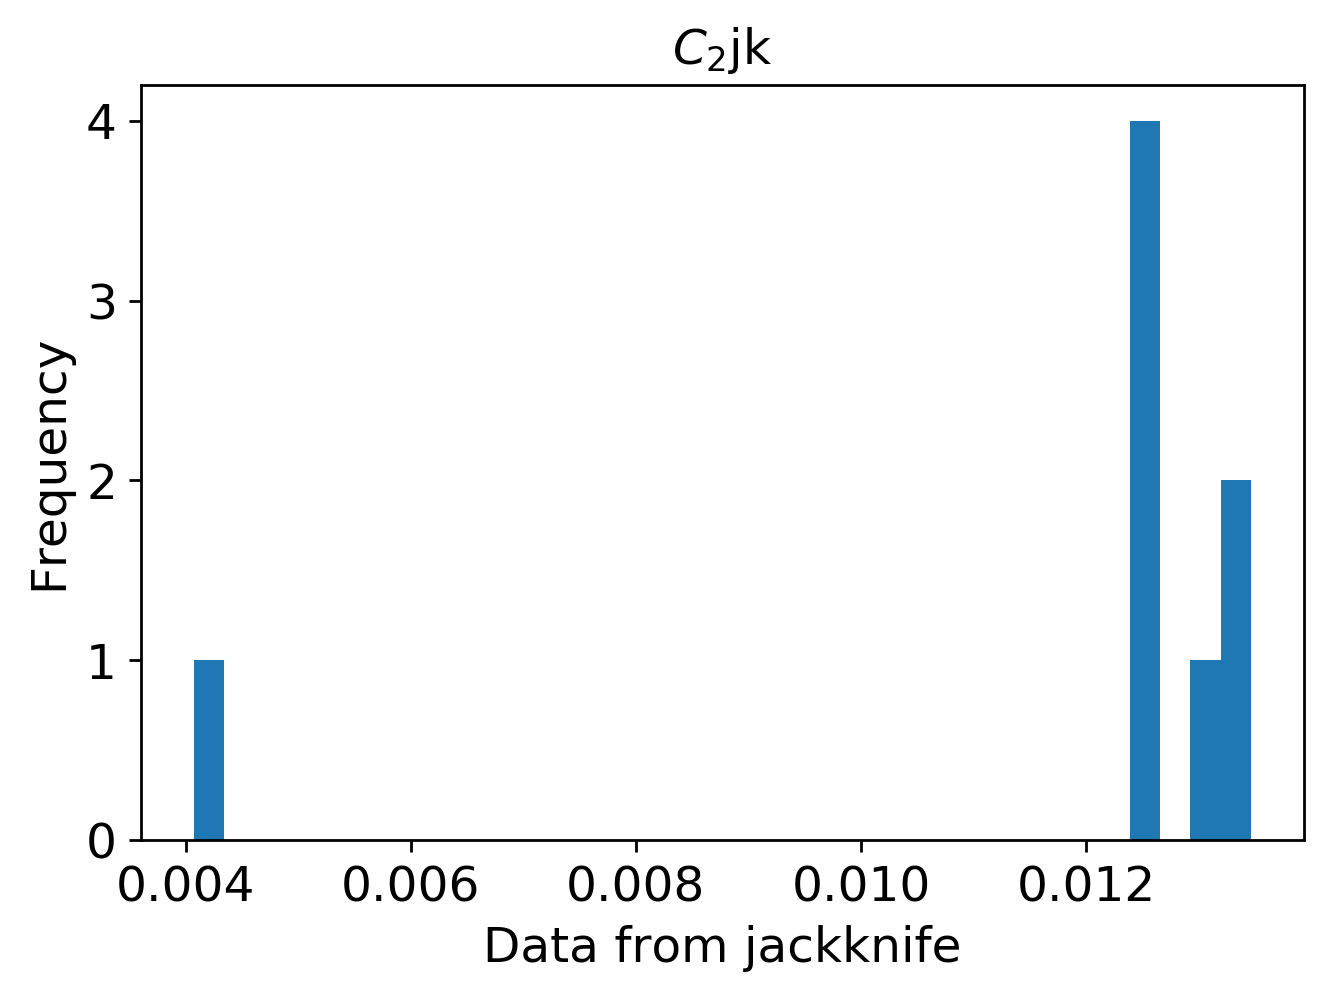

mean: 0.006256494452382352
jk_e: 0.0007306732358374629
CI 0.0014321195422414273


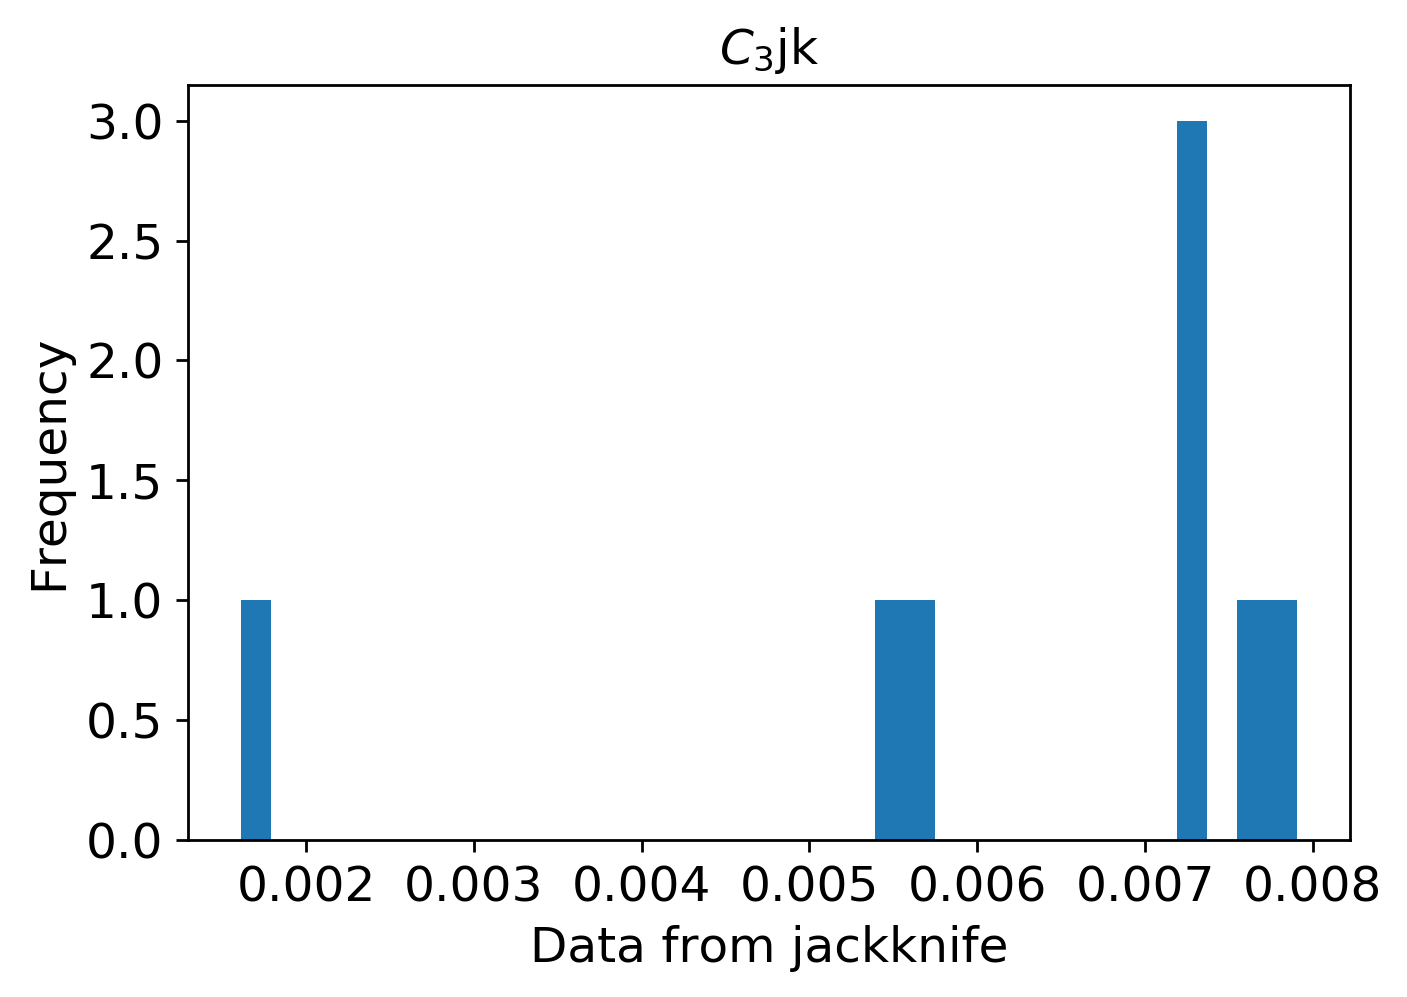

mean: 0.0015859881166446418
jk_e: 0.00034223985144555126
CI 0.0006707901088332805


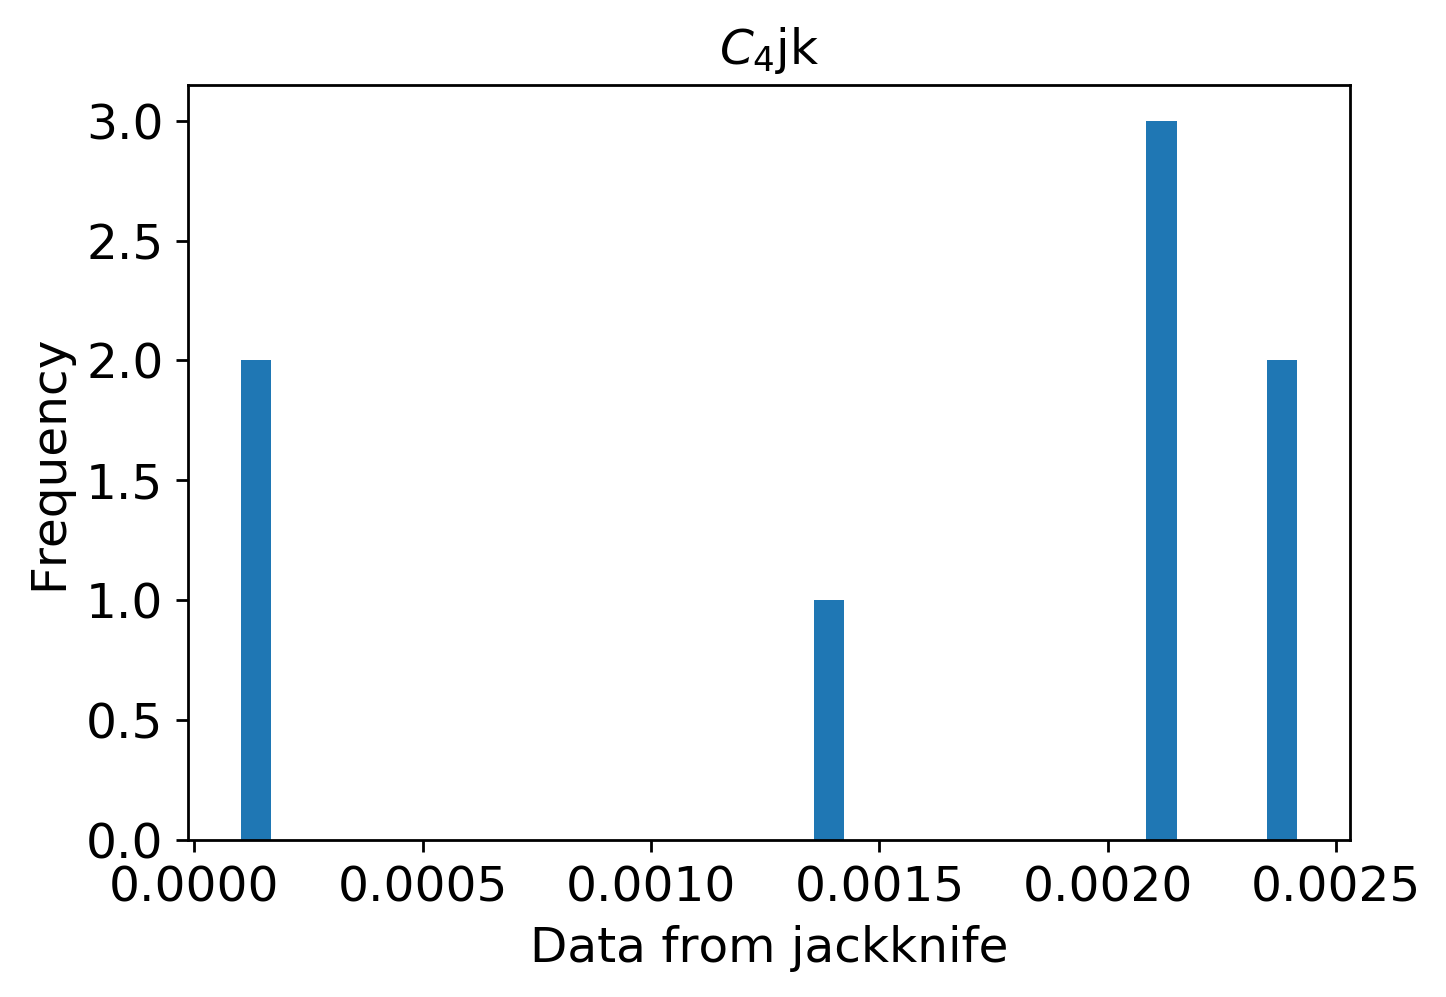

In [13]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g4_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g4_j2_roi770_jogan_5500_400grid/5000/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 4
#gclass_label = ["406 ${\mu}m$", "268 ${\mu}m$",
                #"177 ${\mu}m$", "117 ${\mu}m$"]
topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv('../Journal_2/jogan_gs4_range.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_jogan_gs4.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../Journal_2/jogan_gs4_range.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="cubic", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_jogan_gs4.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk']
jk_er=[]
with open('jk_e_770jogan_g4','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.pdf')
        plt.show()

     distance       489       394       317       255
0    0.000000  0.038239  0.031478  0.011181  0.003198
1  109.646182  0.027764  0.022014  0.007247  0.001860
2  450.682215  0.010153  0.008097  0.002525  0.000523
3  543.078703  0.019464  0.017450  0.005963  0.001467
4  674.221738  0.017932  0.020203  0.009403  0.002442
5  766.825235  0.008901  0.011150  0.005928  0.001497
6  879.030860  0.001445  0.001811  0.000995  0.000255
7  965.302169  0.005323  0.007308  0.004965  0.001357
[[0.70792633 0.63817878 0.57260623 ... 0.0758335  0.07538501 0.07493113]
 [0.20265282 0.17978638 0.15835408 ... 0.0271955  0.02710903 0.02702214]
 [0.32379817 0.2834967  0.24578913 ... 0.02018895 0.01979175 0.01945576]
 ...
 [0.29067941 0.26518264 0.24114747 ... 0.11492859 0.1131736  0.11143209]
 [0.17256288 0.16768581 0.16293725 ... 0.096978   0.09568876 0.09439742]
 [0.33647096 0.3020176  0.26967402 ... 0.0222057  0.02107748 0.0199473 ]]
[[4.41869852e+03 1.51565059e+00 1.14332319e+01 ... 1.81710742e-03
  1.

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


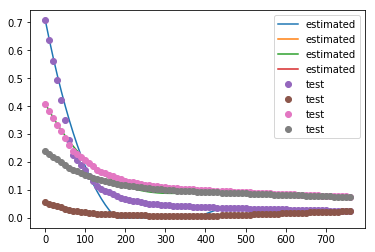

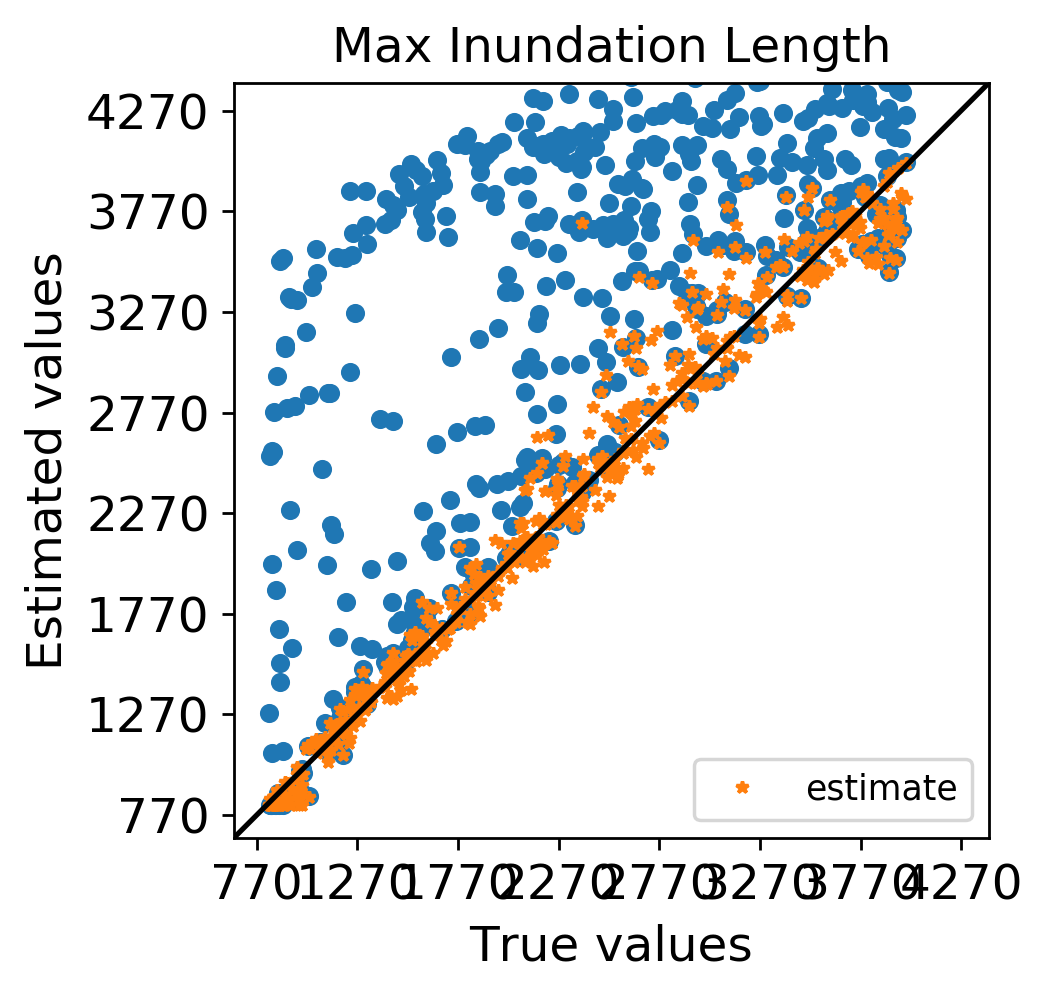

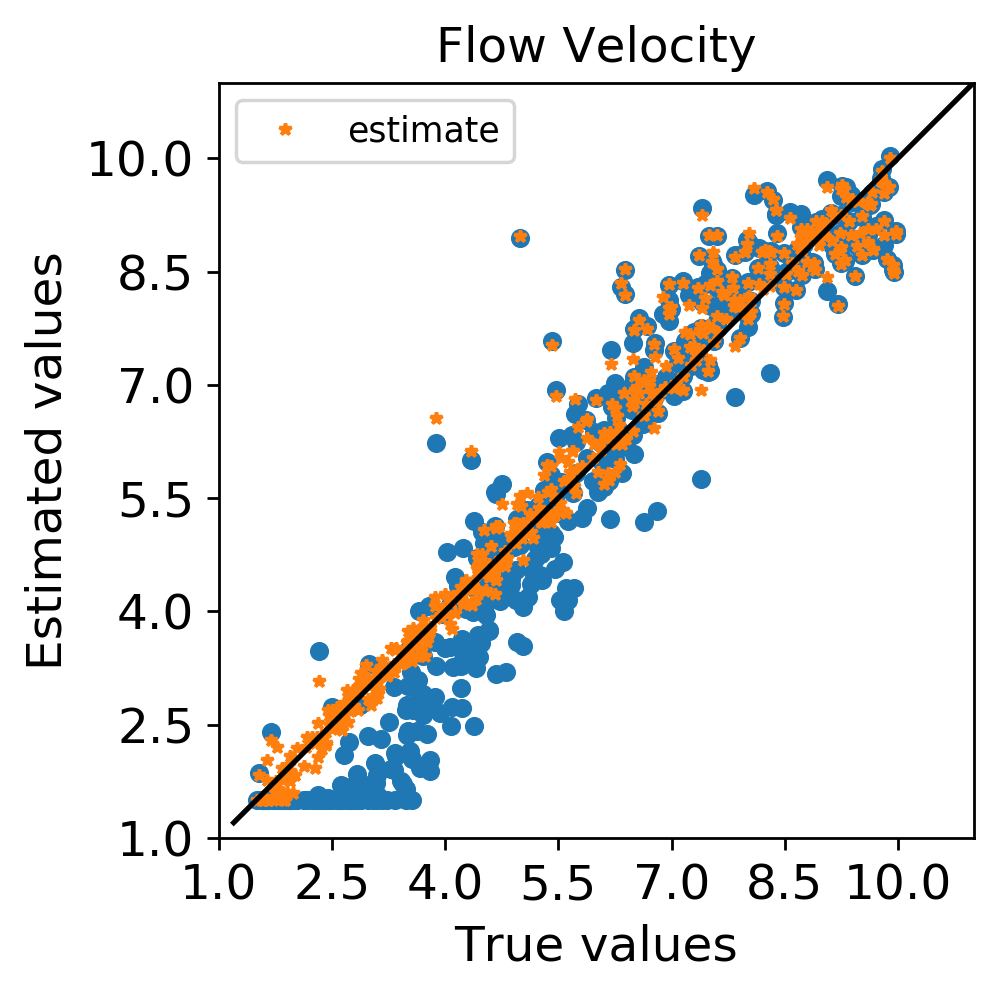

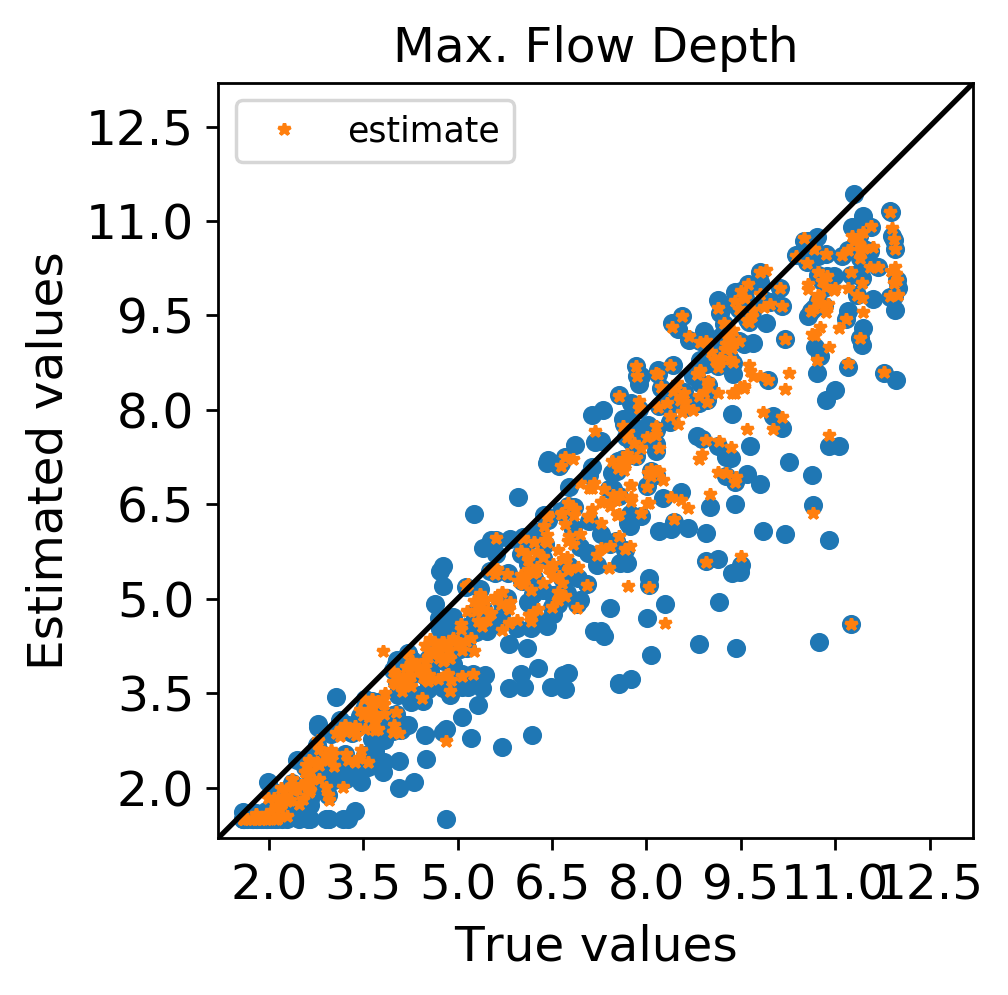

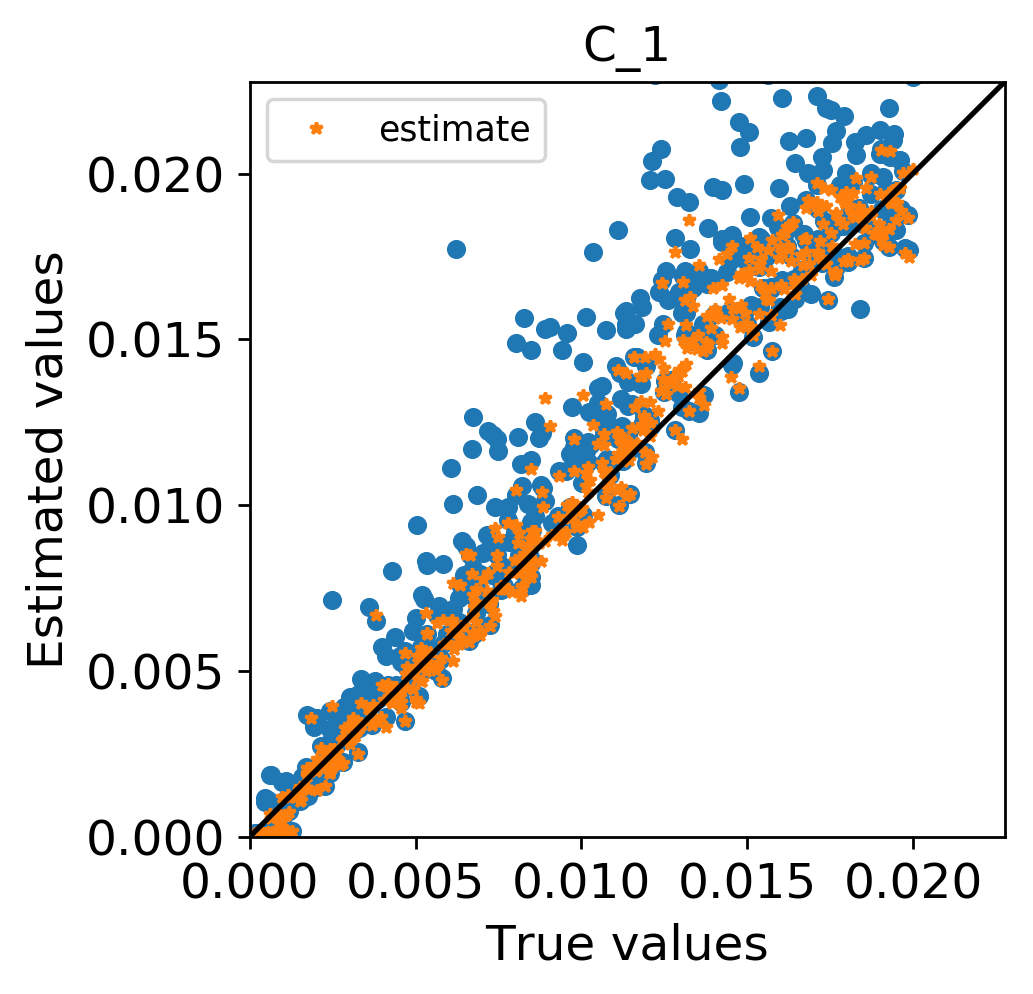

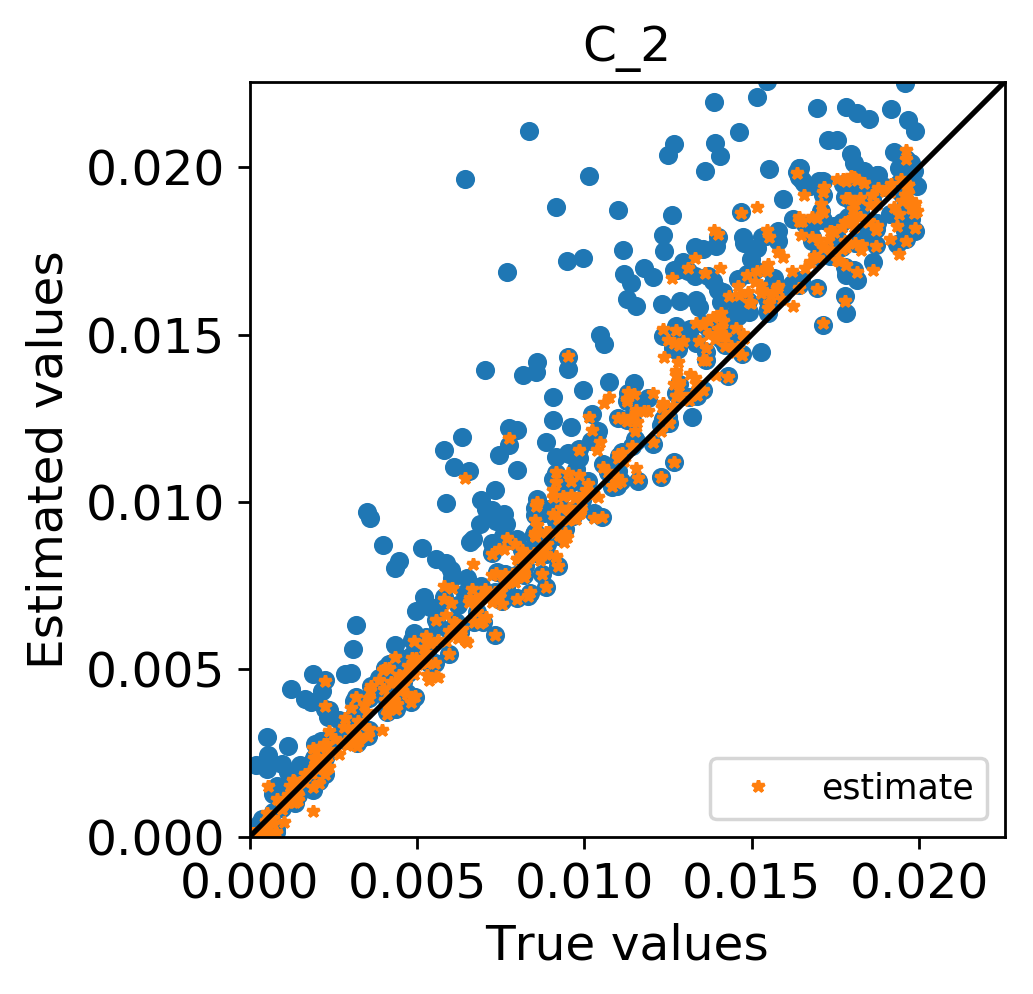

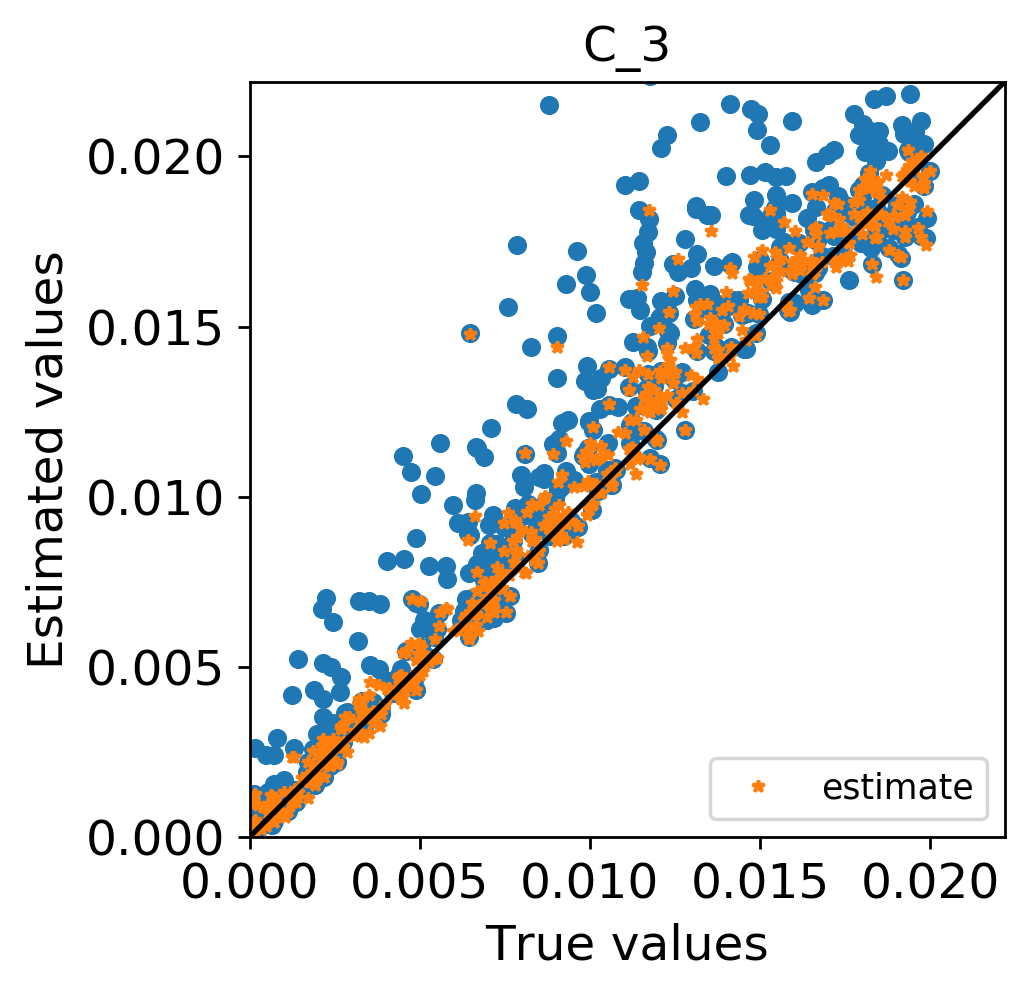

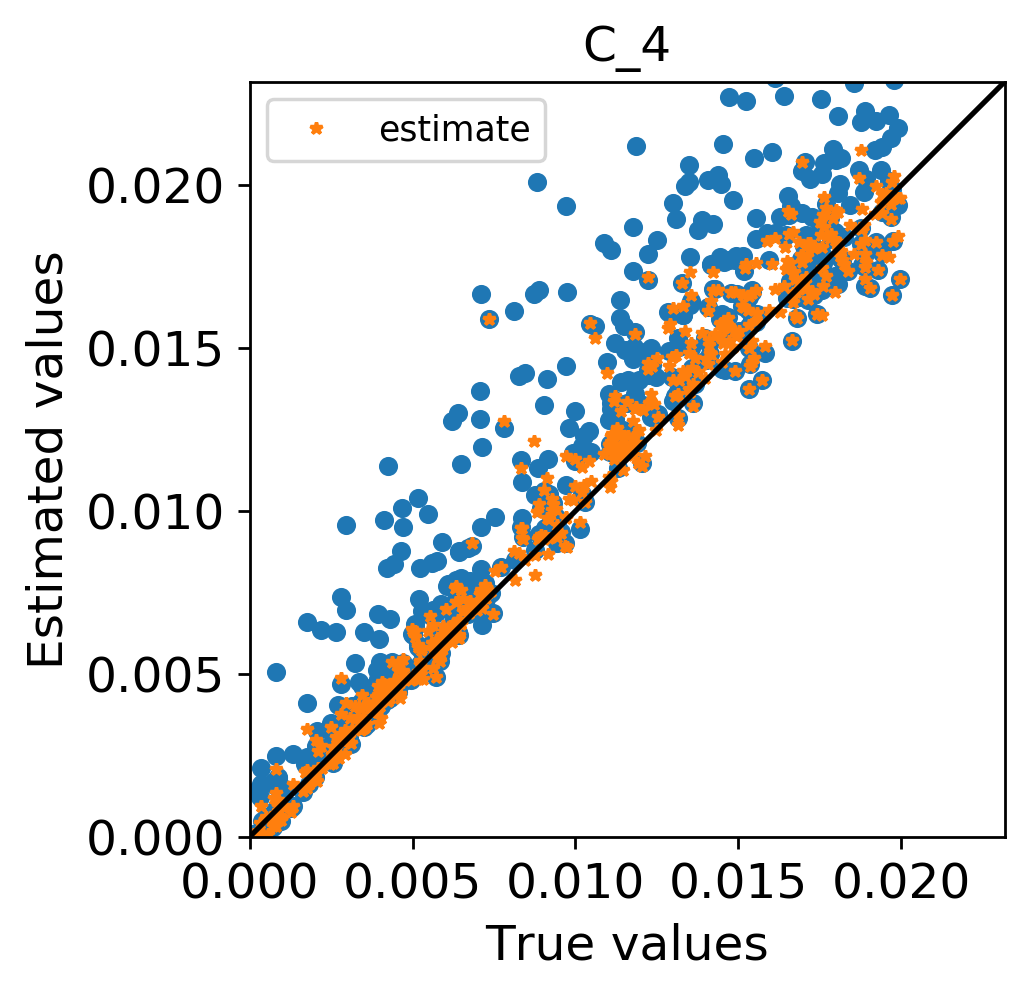

Standard Deviation sample: 791.2491540298618
Mean: 801.9219256149671
mode ModeResult(mode=array([-443.93426875]), count=array([1]))
m 586.243946726267


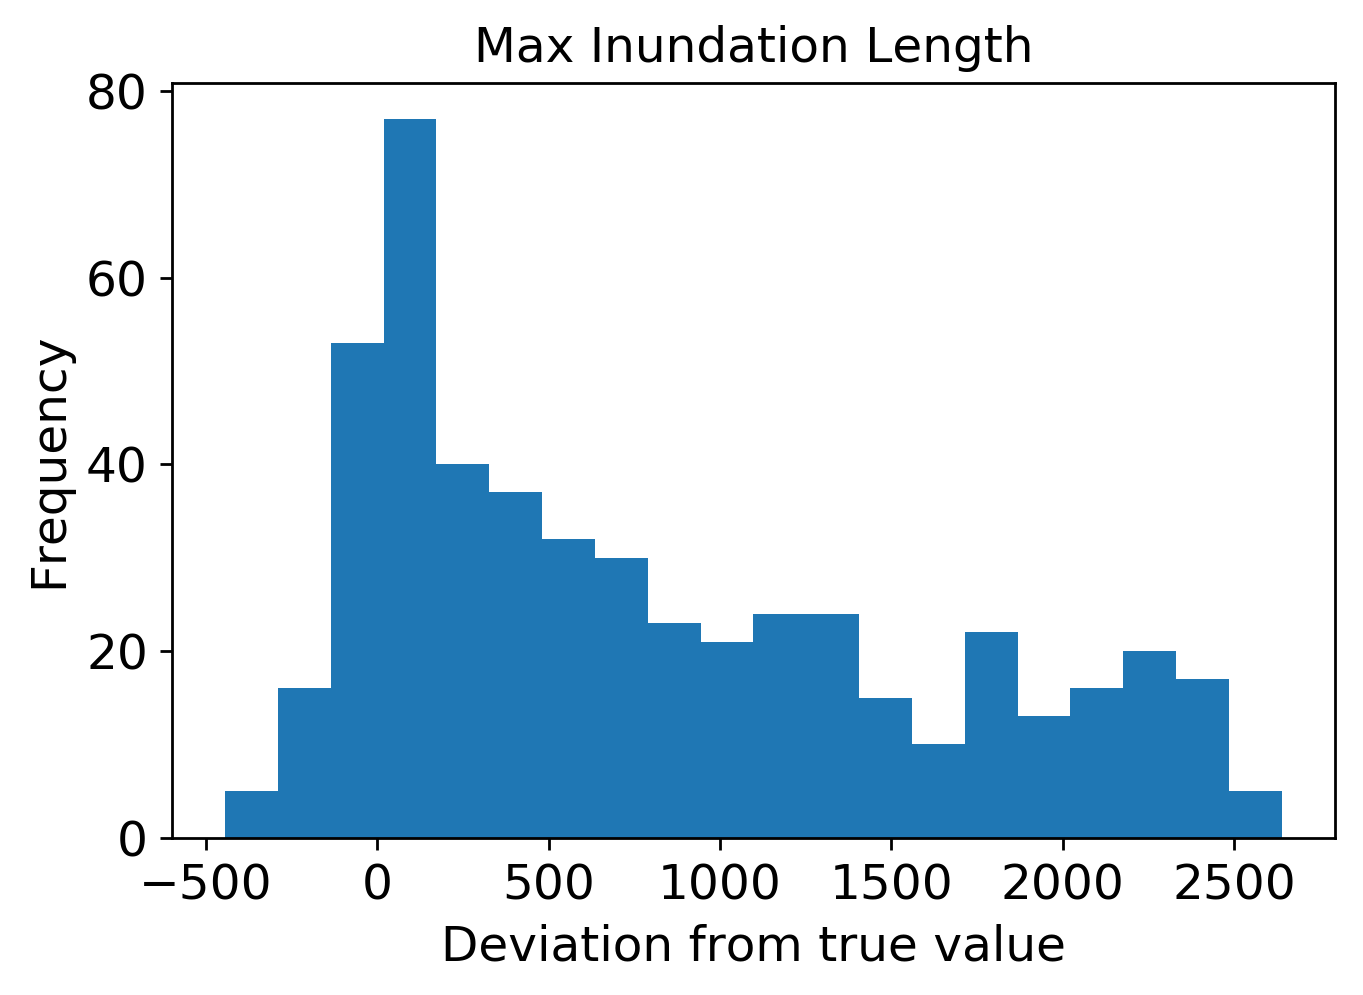

Standard Deviation sample: 0.8009970988513061
Mean: -0.2484468813483293
mode ModeResult(mode=array([-2.06547318]), count=array([1]))
m -0.23156901538013397


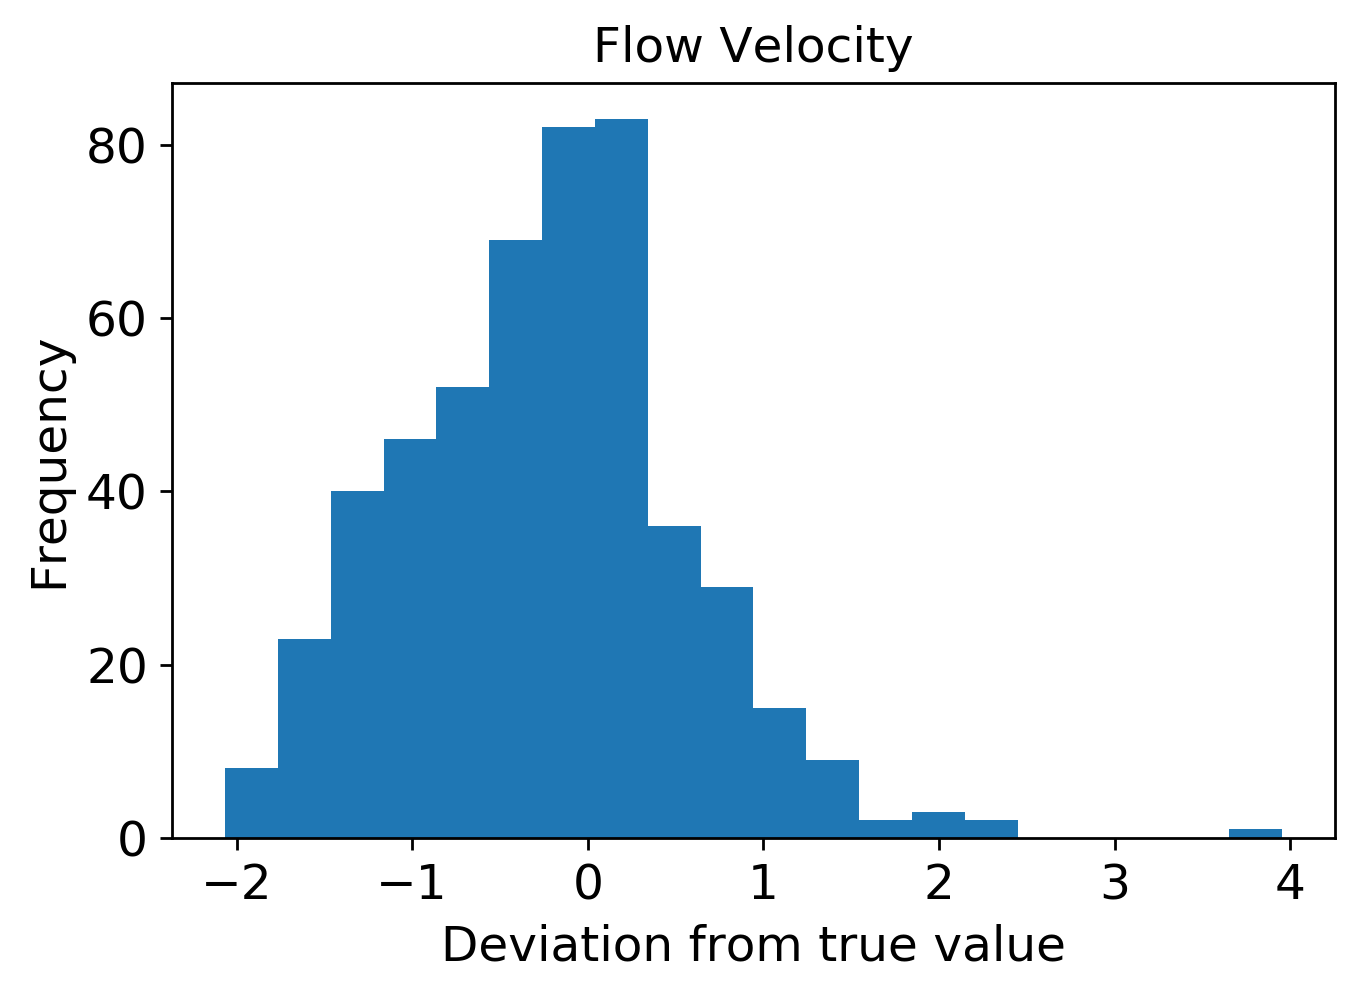

Standard Deviation sample: 1.1219102203648754
Mean: -0.9638372265930379
mode ModeResult(mode=array([-6.64717851]), count=array([1]))
m -0.7078278867479062


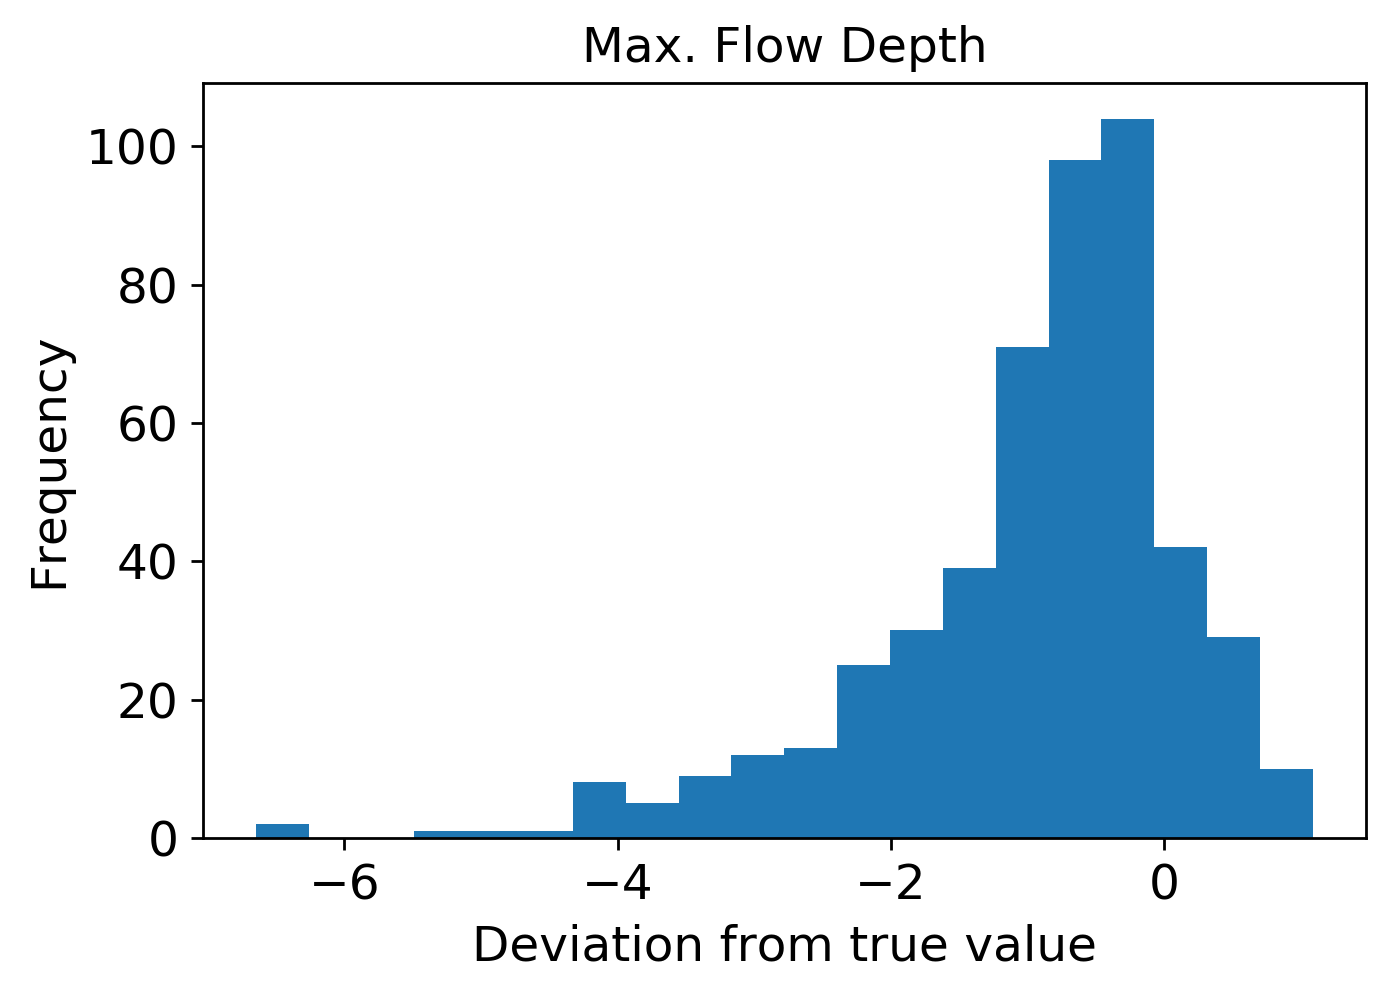

Standard Deviation sample: 0.002076016137650632
Mean: 0.001486540397765825
mode ModeResult(mode=array([-0.00248973]), count=array([1]))
m 0.0008920642969120927


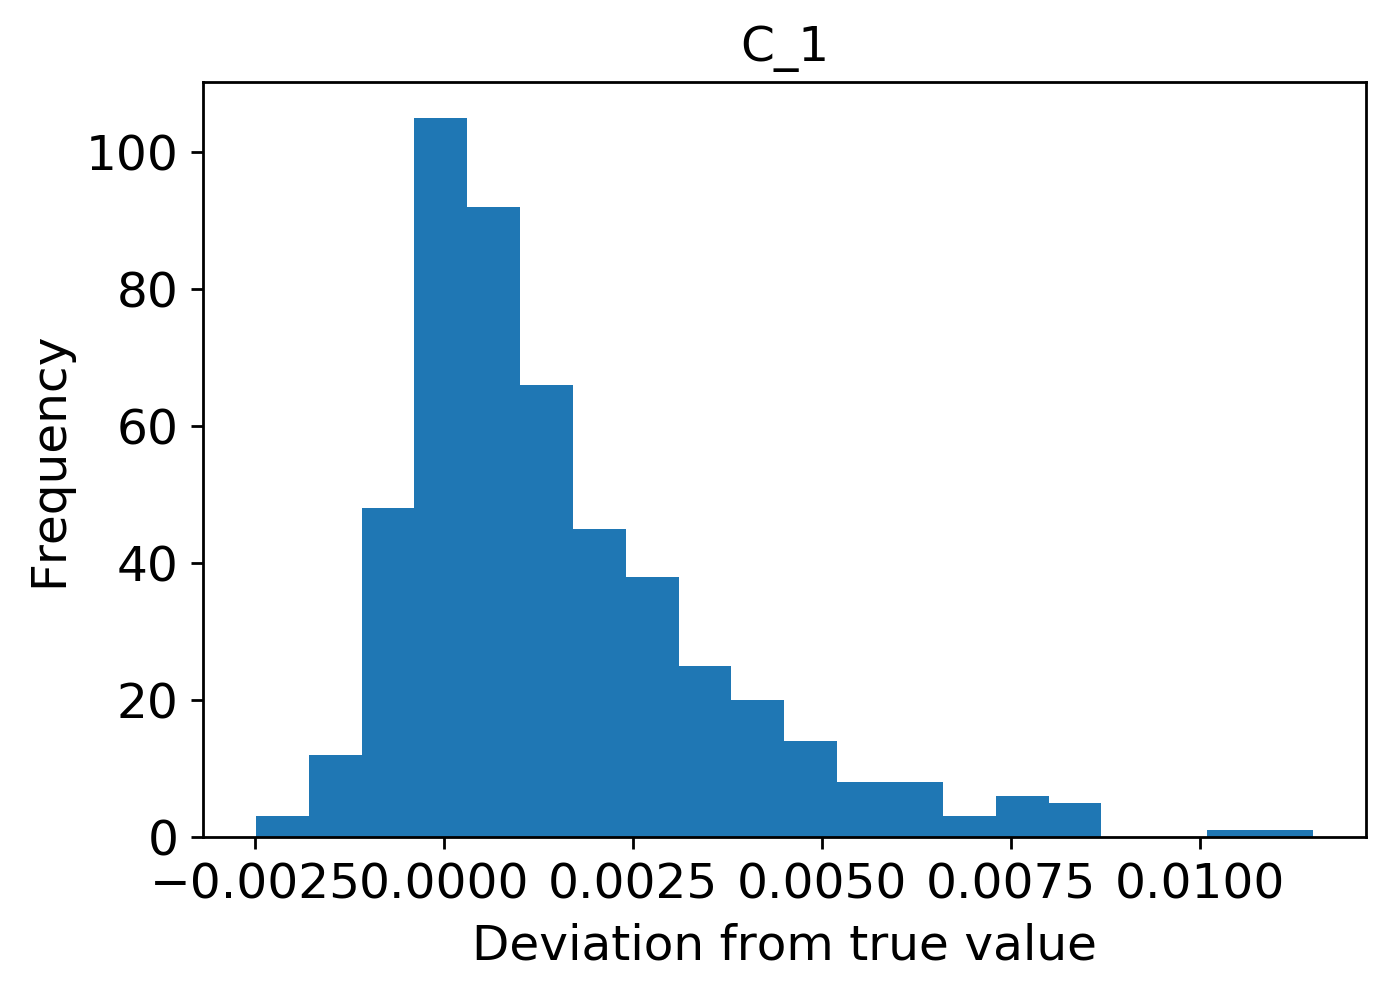

Standard Deviation sample: 0.0021570093082908335
Mean: 0.0014492895376335482
mode ModeResult(mode=array([-0.00216483]), count=array([1]))
m 0.0007912534599931826


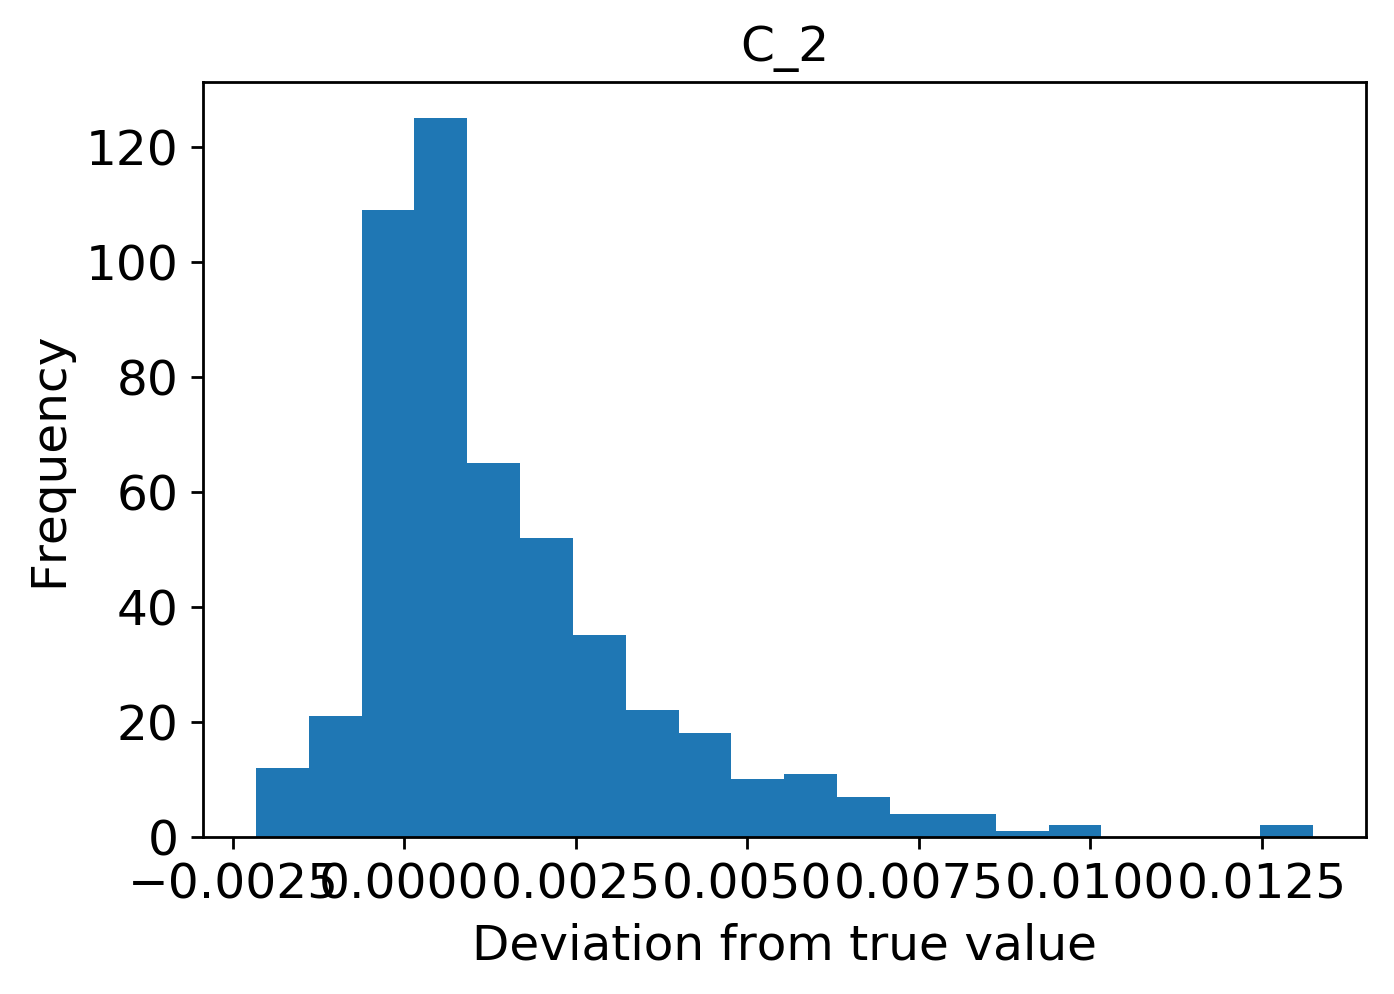

Standard Deviation sample: 0.0021465306881193937
Mean: 0.0016020549632533453
mode ModeResult(mode=array([-0.00283042]), count=array([1]))
m 0.0009915665826437268


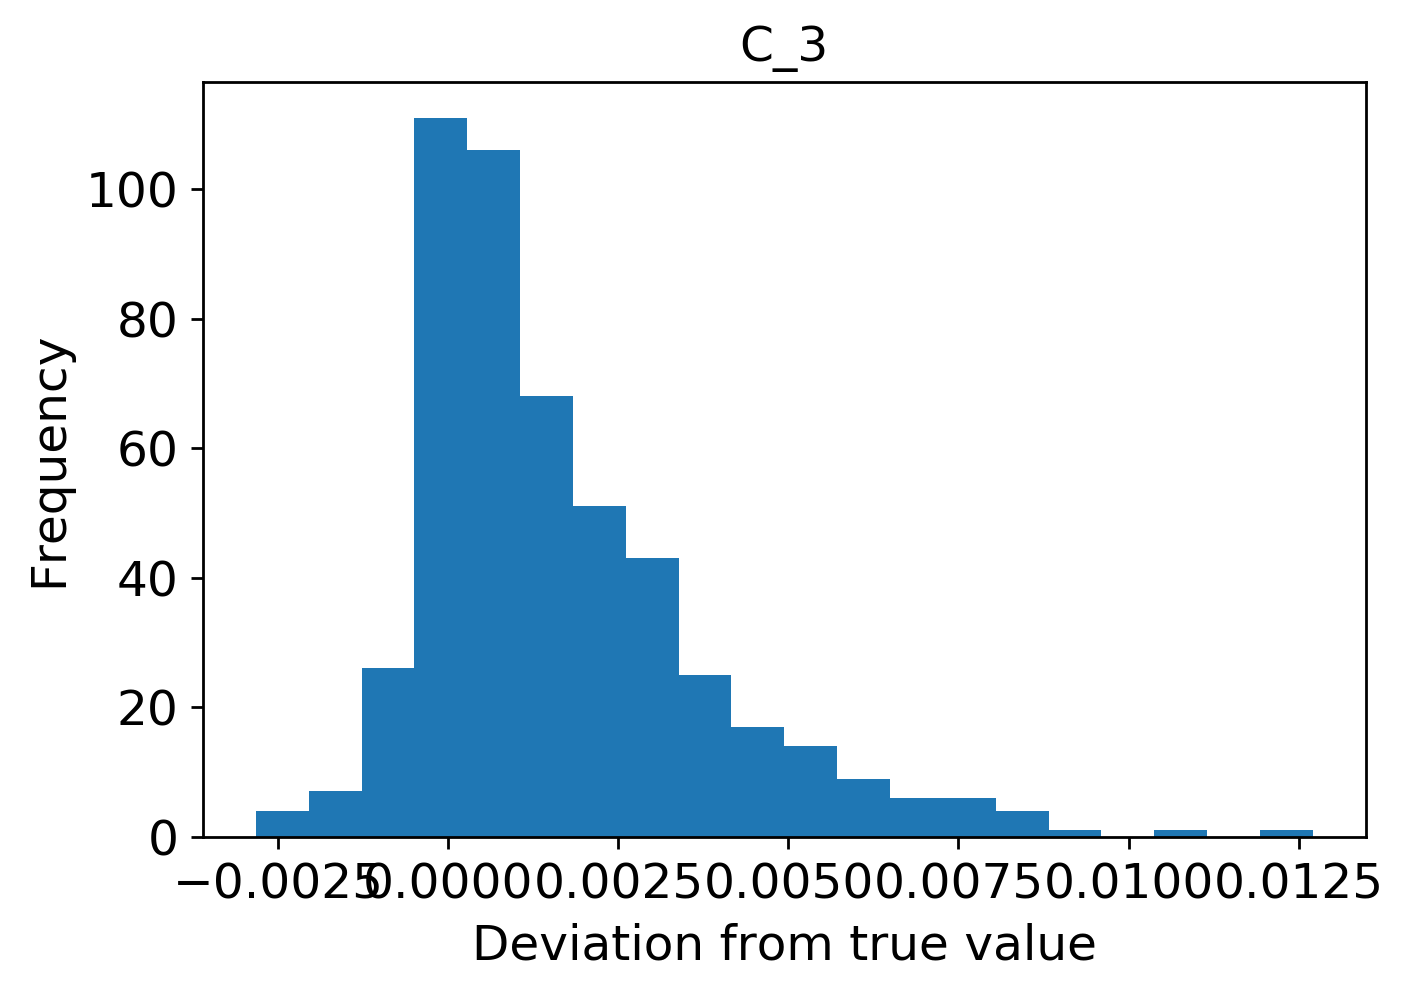

Standard Deviation sample: 0.002243323824081785
Mean: 0.001708382525646652
mode ModeResult(mode=array([-0.00309424]), count=array([1]))
m 0.0010935977114680398


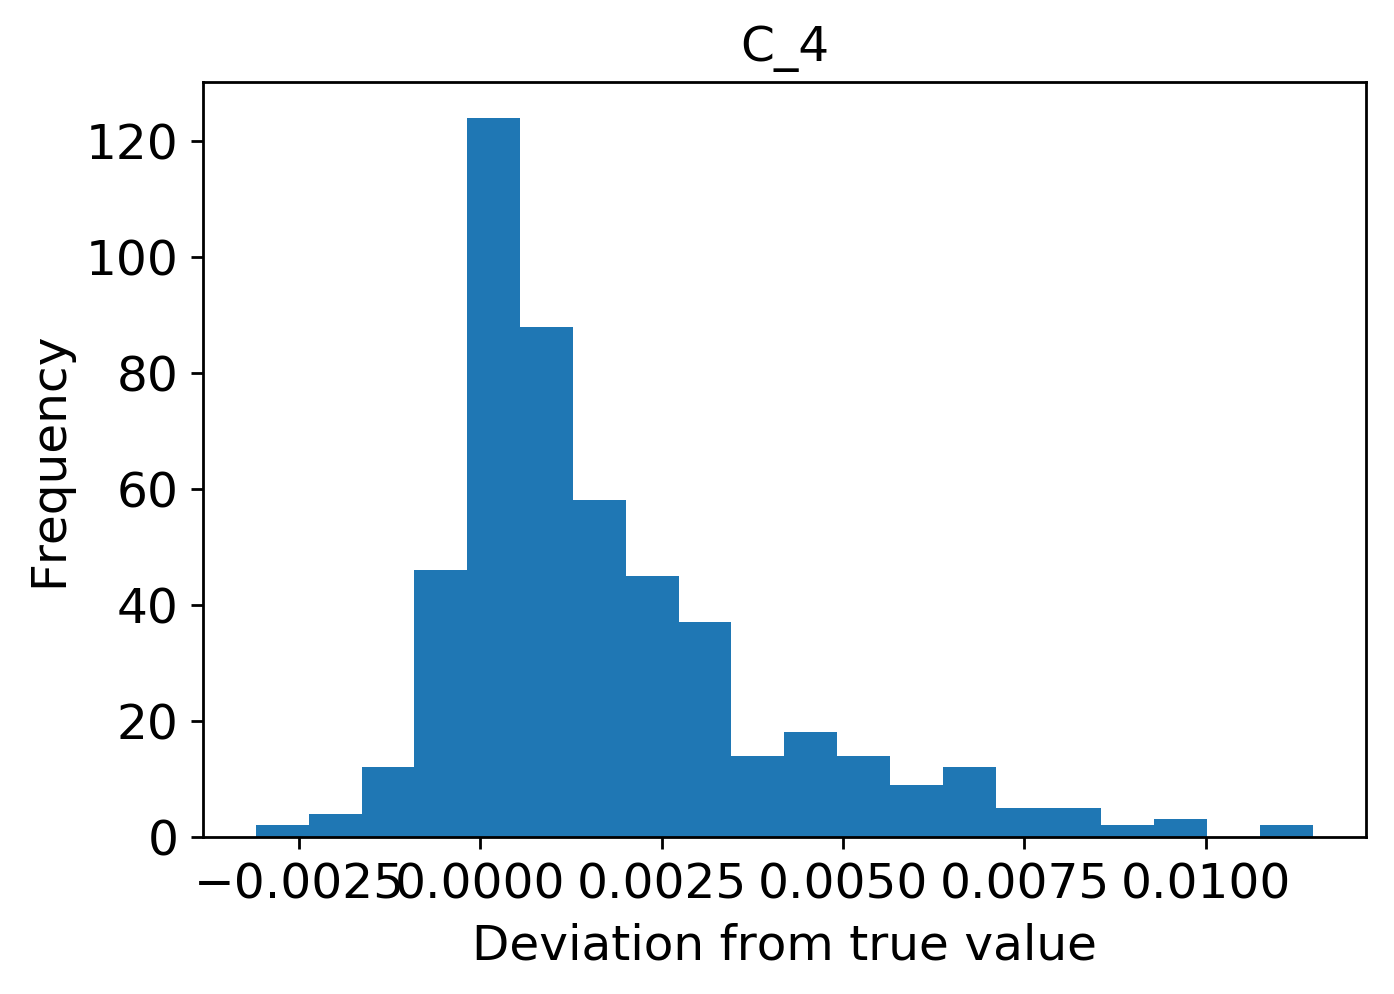

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb
from scipy import stats

import ipdb
#ipdb.set_trace()

datadir = '/home/rimali2009/Journal_2/data_g4_j2_roi770_jogan_5500_400grid/'
resdir = '/home/rimali2009/Journal_2/result_g4_j2_roi770_jogan_5500_400grid/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

# Load test datasets

X_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


# Normalize the test datasets
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
X_test_norm =  (X_test - min_x) / (max_x - min_x)


gclass = 4
gclass_name= ['489','394','317','255']
gclass_label = ["489${\mu}m$","394 ${\mu}m$", "317 ${\mu}m$","255${\mu}m$"]

topodx = 10.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

# Load outcrop data
outcrop = pd.read_csv('../Journal_2/jogan_gs4_range.csv')
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
outcrop_num = len(outcrop['distance'])
print(outcrop)

#Preparation under interpolation
thick_interp_at_outcrop = np.zeros([X_test.shape[0],outcrop_num*gclass])
thick_interp = np.zeros([X_test.shape[0],coord_num*gclass])#Interpolated sample thickness data
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #Index number of sampling point in inverse analysis system
x = np.arange(0,coord_num*topodx,topodx)

# Interpolation of test datasets at the outcrop locations
for i in range(X_test.shape[0]):
    for j in range(gclass):
        f = interp1d(x,X_test_norm[i,j * coord_num : (j+1) * coord_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp_at_outcrop[i,outcrop_num*j:outcrop_num*(j+1)] = f(outcrop['distance']) #Supplemented data

    # Interpolation of test datasets at the grids of the forward model
    for j in range(gclass):
        f = interp1d(outcrop['distance'],thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp[i,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data
    


#Normalize data
thick_interp[thick_interp < 0] = 0
print(thick_interp)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
np.savetxt('outcrop_location_interp.txt',test_result_outcrop, delimiter=',')
test_result=np.loadtxt('outcrop_location_interp.txt', delimiter=',')
test_result_normal = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
resi=test_result-y_test
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4']
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
xymin=[770,1.5,1.5,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005]
stepmin=[770,1.0,2.0,0.000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025]
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)], label='estimated')
for j in range(gclass):
    plt.plot(x,X_test_norm[0,j * coord_num : (j+1) * coord_num],'o',label='test')
    #plt.plot(outcrop['distance'], thick_interp_at_outcrop[0,outcrop_num*j:outcrop_num*(j+1)],'o',label='test')
plt.plot()
plt.legend()


for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(y_test[:,i],test_result[:,i],"o", markersize=4.5)
    plt.plot(y_test[:,i],test_result_normal[:,i],"*",label='estimate',markersize=3.5)
    x=y_test[:,i]
    y=test_result_normal[:,i]
    y2= test_result_normal[:, i]
    max_value = np.max([x, y, y2])
    min_value = np.min([x, y, y2])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('True values',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    #plt.plot(x_lim, y_lim, color = 'k')
    plt.tick_params(labelsize=14,colors='k')
    plt.savefig(resdir+titlelabel[i] + 'outcrop_locationrev' + '.pdf')
    plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('mode',stats.mode(resi[:,i]))
    print('m',np.median(resi[:,i]))
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.pdf')
    plt.show()